In [11]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import traceback
# from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.math as tfmath
import tensorflow.keras as keras
# from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, LeakyReLU, ReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision
# from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm
# from qkeras import quantized_relu, quantized_bits
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [12]:
#preprocessed_SNL_data.h5 is located under s3df /sdf/home/l/lizhx/
home_path = "/fs/ddn/sdf/group/atlas/d/lizhx/"
file_path = home_path + "preprocessed_SNL_data.h5"
with h5py.File(file_path, 'r') as hf:
    X_train = hf['X_train'][:]
    X_test  = hf['X_test'][:]
    Ato4l_data  = hf['Ato4l_data'][:]
    hToTauTau_data  = hf['hToTauTau_data'][:]
    hChToTauNu_data  = hf['hChToTauNu_data'][:]
    leptoquark_data = hf['leptoquark_data'][:]
    print("Data loaded from preprocessed_SNL_data.h5")


Data loaded from preprocessed_SNL_data.h5


In [13]:
def analyze_columns(arr):
    # Check if the input array has 57 columns
    if arr.shape[1] != 57:
        raise ValueError("Input array must have 57 columns")

    for col in range(57):
        column = arr[:, col]
        
        # Calculate statistics
        mean_val = np.mean(column)
        min_val = np.min(column)
        max_val = np.max(column)
        has_nan = np.isnan(column).any()
        
        # Print results
        print(f"Column {col + 1}:")
        print(f"  Mean: {mean_val:.4f}")
        print(f"  Min: {min_val:.4f}")
        print(f"  Max: {max_val:.4f}")
        print(f"  Contains NaN: {has_nan}")
        print()  # Empty line for readability
analyze_columns(X_train)

Column 1:
  Mean: -0.0000
  Min: -1.9571
  Max: 53.1526
  Contains NaN: False

Column 2:
  Mean: 0.0000
  Min: 0.0000
  Max: 0.0000
  Contains NaN: False

Column 3:
  Mean: 0.0000
  Min: -1.7323
  Max: 1.7311
  Contains NaN: False

Column 4:
  Mean: -0.0000
  Min: -0.9537
  Max: 47.1318
  Contains NaN: False

Column 5:
  Mean: -0.0000
  Min: -2.4819
  Max: 2.4821
  Contains NaN: False

Column 6:
  Mean: -0.0000
  Min: -2.3496
  Max: 2.3489
  Contains NaN: False

Column 7:
  Mean: -0.0000
  Min: -0.0355
  Max: 200.8080
  Contains NaN: False

Column 8:
  Mean: -0.0000
  Min: -43.0203
  Max: 43.0213
  Contains NaN: False

Column 9:
  Mean: 0.0000
  Min: -34.6662
  Max: 34.6653
  Contains NaN: False

Column 10:
  Mean: 0.0000
  Min: -0.0108
  Max: 302.0646
  Contains NaN: False

Column 11:
  Mean: -0.0000
  Min: -181.6179
  Max: 181.7817
  Contains NaN: False

Column 12:
  Mean: -0.0000
  Min: -130.9459
  Max: 130.8367
  Contains NaN: False

Column 13:
  Mean: -0.0000
  Min: -0.0028
  Max:

In [14]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def Qmake_encoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs = keras.Input(shape=(input_dim))
#     x = BatchNormalization(name="BN0")(inputs)
    x = Dense(h_dim_1,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense1")(inputs)
#     x = BatchNormalization(name="BN1")(x)
    x = ReLU(name="relu1")(x)
    x = Dense(h_dim_2,
             kernel_initializer=keras.initializers.HeNormal(seed=None),
             bias_initializer=keras.initializers.Zeros(),
             kernel_regularizer=l1_l2(l1=0, l2=l2_factor),
             name = "dense2")(x)    
#     x = BatchNormalization(name="BN2")(x)
    x = ReLU(name="relu2")(x)
    z_mean=Dense(latent_dim, name='z_mean',
                  kernel_initializer=keras.initializers.HeNormal(seed=None),
                  bias_initializer=keras.initializers.Zeros(),
                  kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z_logvar=Dense(latent_dim, name='z_log_var',
                          kernel_initializer=keras.initializers.Zeros(),
                          bias_initializer=keras.initializers.Zeros(),
                          kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=Sampling()([z_mean,z_logvar])
    encoder = keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def Qmake_decoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    l2_factor = 1e-3
    inputs=keras.Input(shape=(latent_dim))
    x=layers.Dense(h_dim_2,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(inputs)
    x=layers.Dense(h_dim_1,
                   activation='relu',
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    z=layers.Dense(input_dim,
                   kernel_initializer=keras.initializers.HeNormal(seed=None),
                   bias_initializer=keras.initializers.Zeros(),
                   kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder

def Qmake_discriminator(input_dim, h_dim_1, h_dim_2, name):
    l2_factor = 1e-3
    inputs = keras.Input(shape=(input_dim))
    x = Dense(h_dim_1,
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros(),
              kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(inputs)
    x = Dense(h_dim_2,
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros(),
              kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)
    x = Dense(1, activation='sigmoid',           
              kernel_initializer=keras.initializers.HeNormal(seed=None),
              bias_initializer=keras.initializers.Zeros(),
              kernel_regularizer=l1_l2(l1=0, l2=l2_factor))(x)

    return keras.Model(inputs, x, name=name)



def custom_mse_loss_with_multi_index_scaling(masked_data, masked_reconstruction):
#     jet_scale = 256/64
#     tau_scale = 128/64
#     muon_scale = 32/64
#     met_scale = 512/64
#     em_scale = 128/64
#   no scaling right now
    jet_scale = 1
    tau_scale = 1
    muon_scale = 1
    met_scale = 1
    em_scale = 1
    # Define the indices and their corresponding scale factors
    scale_dict = {
        0: met_scale,
        3: em_scale, 6: em_scale, 9: em_scale, 12: em_scale,
        15: tau_scale, 18: tau_scale, 21: tau_scale, 24: tau_scale,
        27: jet_scale, 30: jet_scale, 33: jet_scale, 36: jet_scale, 39: jet_scale, 42: jet_scale,
        45: muon_scale, 48: muon_scale, 51: muon_scale, 54: muon_scale
    }

    # Create the scaling tensor
    scale_tensor = tf.ones_like(masked_data)
    for index, factor in scale_dict.items():
        index_mask = tf.one_hot(index, depth=tf.shape(masked_data)[-1])
        scale_tensor += index_mask * (factor - 1)

    # Apply scaling
    scaled_data = masked_data * scale_tensor
    scaled_reconstruction = masked_reconstruction * scale_tensor

    # Hardcoded lists for eta and phi indices
    eta_indices = [4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55]
    phi_indices = [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56]

    batch_size = tf.shape(scaled_reconstruction)[0]
    
    # Set only the first eta (index 1) to zero
    indices = tf.stack([tf.range(batch_size), tf.ones(batch_size, dtype=tf.int32)], axis=1)
    updates = tf.zeros(batch_size)
    scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
    # Apply constraints to eta
    for i in eta_indices:
        indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
        updates = 3 * tf.tanh(scaled_reconstruction[:, i] / 3)
        scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
    
    # Apply constraints to phi
    for i in phi_indices:
        indices = tf.stack([tf.range(batch_size), tf.fill([batch_size], i)], axis=1)
        updates = 3.14159265258979 * tf.tanh(scaled_reconstruction[:, i] / 3.14159265258979)
        scaled_reconstruction = tf.tensor_scatter_nd_update(scaled_reconstruction, indices, updates)
        
    # Calculate MSE using keras.losses.mse
    mse = keras.losses.mse(scaled_data, scaled_reconstruction)

    # Take the sum across all dimensions
    return tf.reduce_mean(mse)

class VAE_GAN_Model(keras.Model):
    def __init__(self, encoder, decoder, discriminator_xz, discriminator_xx, discriminator_zz,
                  steps_per_epoch=3125, 
                cycle_length=10, min_beta=0.1, max_beta=0.85, gamma = 1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator_xz = discriminator_xz
        self.discriminator_xx = discriminator_xx
        self.discriminator_zz = discriminator_zz
        self.steps_per_epoch = steps_per_epoch
        self.cycle_length = tf.cast(cycle_length, tf.float32)
        self.min_beta = tf.cast(min_beta, tf.float32)
        self.max_beta = tf.cast(max_beta, tf.float32)
        self.gamma = gamma
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.discriminator_loss_tracker_xz = keras.metrics.Mean(name="discriminator_loss_xz")
        self.discriminator_loss_tracker_xx = keras.metrics.Mean(name="discriminator_loss_xx")
        self.discriminator_loss_tracker_zz = keras.metrics.Mean(name="discriminator_loss_zz")
        self.beta_tracker = keras.metrics.Mean(name="beta")
        self.beta = tf.Variable(min_beta, dtype=tf.float32)

    def compile(self, optimizer, **kwargs):
        super(VAE_GAN_Model, self).compile(**kwargs)
        # Set the optimizer for the entire model (encoder + decoder + discriminator)
        self.optimizer = optimizer

        # Collect trainable variables from encoder, decoder, and discriminator
        trainable_variables = (
            self.encoder.trainable_weights + 
            self.decoder.trainable_weights + 
            self.discriminator_xz.trainable_weights +
            self.discriminator_xx.trainable_weights + 
            self.discriminator_zz.trainable_weights
        )
        # Build the optimizer with the full variable list
        self.optimizer.build(trainable_variables)


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.discriminator_loss_tracker_xz,
            self.discriminator_loss_tracker_xx,
            self.discriminator_loss_tracker_zz,
            self.beta_tracker,
        ]

    def cyclical_annealing_beta(self, epoch):
        cycle = tf.floor(1.0 + epoch / self.cycle_length)
        x = tf.abs(epoch / self.cycle_length - cycle + 1)
        return self.min_beta + (self.max_beta - self.min_beta) * tf.minimum(x, 1.0)

    def train_step(self, x_data):
        epoch = tf.cast(self.optimizer.iterations / self.steps_per_epoch, tf.float32)
        self.beta.assign(self.cyclical_annealing_beta(epoch))

        with tf.GradientTape() as tape_vae, tf.GradientTape() as tape_xz, tf.GradientTape() as tape_xx, tf.GradientTape() as tape_zz:
            z_mean, z_log_var, z_gen = self.encoder(x_data)
            x_reconstruction = self.decoder(z_gen)
            z_random = tf.random.normal(shape=tf.shape(z_gen))
            x_gen = self.decoder(z_random)
            _, _, z_reconstruction = self.encoder(x_gen)

            mask = K.cast(K.not_equal(x_data, 0), K.floatx())
            reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask * x_data, mask * x_reconstruction) 
            reconstruction_loss *= (1 - self.beta)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss) * self.beta

            l_enc = self.discriminator_xz(tf.concat([x_data, z_gen], axis=1))
            l_gen = self.discriminator_xz(tf.concat([x_gen, z_random], axis=1))

            real_xx = self.discriminator_xx(x_data)
            fake_xx = self.discriminator_xx(x_reconstruction)
            # fake_xx = self.discriminator_xx(x_gen)

            real_zz = self.discriminator_zz(z_random)
            fake_zz = self.discriminator_zz(z_reconstruction)

            # dis_loss_xz = keras.losses.binary_crossentropy(tf.ones_like(l_enc), l_enc) + keras.losses.binary_crossentropy(tf.zeros_like(l_gen), l_gen)
            dis_loss_xx = keras.losses.binary_crossentropy(tf.ones_like(real_xx), real_xx) + keras.losses.binary_crossentropy(tf.zeros_like(fake_xx), fake_xx)
            dis_loss_zz = keras.losses.binary_crossentropy(tf.ones_like(real_zz), real_zz) + keras.losses.binary_crossentropy(tf.zeros_like(fake_zz), fake_zz)

            gen_loss_xz = keras.losses.binary_crossentropy(tf.ones_like(l_gen), l_gen)
            enc_loss_xz = keras.losses.binary_crossentropy(tf.zeros_like(l_enc), l_enc)
            dis_loss_xz = gen_loss_xz + enc_loss_xz

            loss_vae = reconstruction_loss + kl_loss
            cycle_consistency_loss = dis_loss_xx + dis_loss_zz
            loss_discriminator =(dis_loss_xz + dis_loss_xx + dis_loss_zz)
            loss_decoder = (gen_loss_xz + cycle_consistency_loss)
            loss_encoder = (enc_loss_xz + cycle_consistency_loss)
            
            total_loss = loss_vae + self.gamma * (loss_decoder + loss_encoder)
            # total_loss = (loss_discriminator + cycle_consistency_loss)


        vae_grads = tape_vae.gradient(total_loss, self.encoder.trainable_weights + self.decoder.trainable_weights)
        disc_grads_xz = tape_xz.gradient(dis_loss_xz, self.discriminator_xz.trainable_weights)
        disc_grads_xx = tape_xx.gradient(dis_loss_xx, self.discriminator_xx.trainable_weights)
        disc_grads_zz = tape_zz.gradient(dis_loss_zz, self.discriminator_zz.trainable_weights)

        self.optimizer.apply_gradients(zip(vae_grads, self.encoder.trainable_weights + self.decoder.trainable_weights))
        self.optimizer.apply_gradients(zip(disc_grads_xz, self.discriminator_xz.trainable_weights))
        self.optimizer.apply_gradients(zip(disc_grads_xx, self.discriminator_xx.trainable_weights))
        self.optimizer.apply_gradients(zip(disc_grads_zz, self.discriminator_zz.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.discriminator_loss_tracker_xz.update_state(dis_loss_xz)
        self.discriminator_loss_tracker_xx.update_state(dis_loss_xx)
        self.discriminator_loss_tracker_zz.update_state(dis_loss_zz)
        self.beta_tracker.update_state(self.beta)

        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "discriminator_loss_xz": self.discriminator_loss_tracker_xz.result(),
            "discriminator_loss_xx": self.discriminator_loss_tracker_xx.result(),
            "discriminator_loss_zz": self.discriminator_loss_tracker_zz.result(),
            "beta": self.beta_tracker.result(),
        }

    def test_step(self, x_data):
        mask = K.cast(K.not_equal(x_data, 0), K.floatx())
        # reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask * data, mask * reconstruction) * (1 - self.beta)

        z_mean, z_log_var, z_gen = self.encoder(x_data)
        x_reconstruction = self.decoder(z_gen)
        z_random = tf.random.normal(shape=tf.shape(z_gen))
        x_gen = self.decoder(z_random)
        _, _, z_reconstruction = self.encoder(x_gen)

        mask = K.cast(K.not_equal(x_data, 0), K.floatx())
        reconstruction_loss = custom_mse_loss_with_multi_index_scaling(mask * x_data, mask * x_reconstruction) 
        reconstruction_loss *= (1 - self.beta)
        
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss) * self.beta

        l_enc = self.discriminator_xz(tf.concat([x_data, z_gen], axis=1))
        l_gen = self.discriminator_xz(tf.concat([x_gen, z_random], axis=1))

        real_xx = self.discriminator_xx(x_data)
        fake_xx = self.discriminator_xx(x_reconstruction)
        # fake_xx = self.discriminator_xx(x_gen)

        real_zz = self.discriminator_zz(z_random)
        fake_zz = self.discriminator_zz(z_reconstruction)

        # dis_loss_xz = keras.losses.binary_crossentropy(tf.ones_like(l_enc), l_enc) + keras.losses.binary_crossentropy(tf.zeros_like(l_gen), l_gen)
        dis_loss_xx = keras.losses.binary_crossentropy(tf.ones_like(real_xx), real_xx) + keras.losses.binary_crossentropy(tf.zeros_like(fake_xx), fake_xx)
        dis_loss_zz = keras.losses.binary_crossentropy(tf.ones_like(real_zz), real_zz) + keras.losses.binary_crossentropy(tf.zeros_like(fake_zz), fake_zz)

        gen_loss_xz = keras.losses.binary_crossentropy(tf.ones_like(l_gen), l_gen)
        enc_loss_xz = keras.losses.binary_crossentropy(tf.zeros_like(l_enc), l_enc)
        dis_loss_xz = gen_loss_xz + enc_loss_xz

        loss_vae = reconstruction_loss + kl_loss
        cycle_consistency_loss = dis_loss_xx + dis_loss_zz
        loss_discriminator =(dis_loss_xz + dis_loss_xx + dis_loss_zz)
        loss_decoder = (gen_loss_xz + cycle_consistency_loss)
        loss_encoder = (enc_loss_xz + cycle_consistency_loss)
        
        total_loss = loss_vae + self.gamma * (loss_decoder + loss_encoder)
        # total_loss = (loss_discriminator + cycle_consistency_loss)

        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "discriminator_loss_xz": dis_loss_xz,
            "discriminator_loss_xx": dis_loss_xx,
            "discriminator_loss_zz": dis_loss_zz,
            "beta": self.beta,
        }

    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction,
        }


In [15]:
class CustomEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def __init__(self, monitor='val_loss', patience=0, restore_best_weights=False, **kwargs):
        super().__init__(monitor=monitor, patience=patience, restore_best_weights=restore_best_weights, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if isinstance(current, np.ndarray):
            current = current.mean()  # Take the mean if it's an array
        logs[self.monitor] = current
        super().on_epoch_end(epoch, logs)


In [16]:
def weighted_mse(y_true, y_pred, sample_weight):
    return tf.reduce_mean(tf.multiply(sample_weight, tf.square(y_true - y_pred)))

In [17]:
NUM_EPOCHS = 100
BATCH_SIZE = 16384 # 1024
STOP_PATIENCE = 15
LR_PATIENCE = 10

In [18]:
# Hyperparameters
input_dim = X_train.shape[1]
h_dim_1 = 32
h_dim_2 = 16
latent_dim = 3
gamma = 1000

encoder = Qmake_encoder_set_weights(input_dim, h_dim_1, h_dim_2, latent_dim)
decoder = Qmake_decoder_set_weights(input_dim, h_dim_1, h_dim_2, latent_dim)
discriminator_xz = Qmake_discriminator(input_dim+latent_dim, h_dim_1, h_dim_2, name="discriminator_xz")
discriminator_xx = Qmake_discriminator(input_dim, h_dim_1, h_dim_2, name="discriminator_xx")
discriminator_zz = Qmake_discriminator(latent_dim, h_dim_1, h_dim_2, name="discriminator_zz")

steps_per_epoch = X_train.shape[0] // BATCH_SIZE
gan_vae = VAE_GAN_Model(encoder, decoder, discriminator_xz, discriminator_xx, discriminator_zz, steps_per_epoch=steps_per_epoch, min_beta=0.1, max_beta=0.8, gamma=gamma)
opt = keras.optimizers.Adam(learning_rate=0.001)
gan_vae.compile(optimizer=opt,weighted_metrics=[weighted_mse])
opt = keras.optimizers.Adam(learning_rate=0.001)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 57)]         0           []                               
                                                                                                  
 dense1 (Dense)                 (None, 32)           1856        ['input_6[0][0]']                
                                                                                                  
 relu1 (ReLU)                   (None, 32)           0           ['dense1[0][0]']                 
                                                                                                  
 dense2 (Dense)                 (None, 16)           528         ['relu1[0][0]']                  
                                                                                            

In [109]:
# fit model & save weights

# early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
early_stopping = CustomEarlyStopping(
    monitor='val_loss',
    patience=STOP_PATIENCE,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

tf.keras.backend.clear_session()
history = gan_vae.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)
gan_vae.save_weights(filepath=home_path+'software_dev/trained_models/adversarial/toyGAN_full/', save_format='tf')

Epoch 1/100
157/157 [==============================] - 45s 252ms/step - loss: 3189.6762 - reco_loss: 5.7682 - kl_loss: 0.9452 - discriminator_loss_xz: 0.1787 - discriminator_loss_xx: 0.3322 - discriminator_loss_zz: 0.2988 - beta: 0.2120 - val_loss: 112.0750 - val_reco_loss: 9.3178 - val_kl_loss: 1.8399 - val_discriminator_loss_xz: 6.1646e-04 - val_discriminator_loss_xx: 0.0280 - val_discriminator_loss_zz: 0.0221 - val_beta: 0.3240 - lr: 0.0010
Epoch 2/100
157/157 [==============================] - 37s 239ms/step - loss: 78.0213 - reco_loss: 8.1015 - kl_loss: 2.3660 - discriminator_loss_xz: 5.9820e-04 - discriminator_loss_xx: 0.0123 - discriminator_loss_zz: 0.0102 - beta: 0.4374 - val_loss: 25.0744 - val_reco_loss: 4.6230 - val_kl_loss: 2.5729 - val_discriminator_loss_xz: 3.2257e-04 - val_discriminator_loss_xx: 0.0042 - val_discriminator_loss_zz: 0.0046 - val_beta: 0.5494 - lr: 0.0010
Epoch 3/100
157/157 [==============================] - 38s 245ms/step - loss: 21.2629 - reco_loss: 3.77

In [11]:
best_epoch = np.argmin(history.history['val_loss'])  # Best epoch index based on validation loss

# Access the best metrics
best_val_loss = history.history['val_loss'][best_epoch]
best_loss = history.history['loss'][best_epoch]
print(f"Best epoch: {best_epoch}") 
print(f"Best training loss: {best_loss}")
print(f"Best validation loss: {best_val_loss}")

Best epoch: 4
Best training loss: 11013.046875
Best validation loss: 6564.4814453125


In [14]:
# iterate 20 times
for i in range(0,10):
    encoder = Qmake_encoder_set_weights(input_dim, h_dim_1, h_dim_2, latent_dim)
    decoder = Qmake_decoder_set_weights(input_dim, h_dim_1, h_dim_2, latent_dim)
    discriminator_xz = Qmake_discriminator(input_dim+latent_dim, h_dim_1, h_dim_2, name="discriminator_xz")
    discriminator_xx = Qmake_discriminator(input_dim, h_dim_1, h_dim_2, name="discriminator_xx")
    discriminator_zz = Qmake_discriminator(latent_dim, h_dim_1, h_dim_2, name="discriminator_zz")

    steps_per_epoch = X_train.shape[0] // BATCH_SIZE
    gan_vae = VAE_GAN_Model(encoder, decoder, discriminator_xz, discriminator_xx, discriminator_zz, steps_per_epoch=steps_per_epoch, min_beta=0.1, max_beta=0.8, gamma=1)
    opt = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1000)
    gan_vae.compile(optimizer=opt,weighted_metrics=[weighted_mse])

    early_stopping = CustomEarlyStopping(
        monitor='val_loss',
        patience=STOP_PATIENCE,
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)
    callbacks = [early_stopping, reduce_lr]

    tf.keras.backend.clear_session()
    history = gan_vae.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, shuffle=True)
    gan_vae.save_weights(filepath=home_path+f'software_dev/trained_models/adversarial_full/gamma1e00/iter_{i}/', save_format='tf')

Epoch 1/100
157/157 [==============================] - 54s 275ms/step - loss: 5.6121 - reco_loss: 1.8250 - kl_loss: 0.1576 - discriminator_loss_xz: 0.1637 - discriminator_loss_xx: 0.2622 - discriminator_loss_zz: 0.3534 - beta: 0.2120 - val_loss: 0.8228 - val_reco_loss: 0.7666 - val_kl_loss: 0.0470 - val_discriminator_loss_xz: 0.0018 - val_discriminator_loss_xx: 0.0013 - val_discriminator_loss_zz: 0.0024 - val_beta: 0.3240 - lr: 0.0010
Epoch 2/100
157/157 [==============================] - 40s 256ms/step - loss: 0.6947 - reco_loss: 0.5837 - kl_loss: 0.0819 - discriminator_loss_xz: 0.0055 - discriminator_loss_xx: 0.0091 - discriminator_loss_zz: 7.3186e-04 - beta: 0.4374 - val_loss: 0.5363 - val_reco_loss: 0.5043 - val_kl_loss: 0.0301 - val_discriminator_loss_xz: 3.1327e-04 - val_discriminator_loss_xx: 5.2514e-04 - val_discriminator_loss_zz: 2.8889e-04 - val_beta: 0.5494 - lr: 0.0010
Epoch 3/100
157/157 [==============================] - 40s 256ms/step - loss: 0.3966 - reco_loss: 0.3789 -

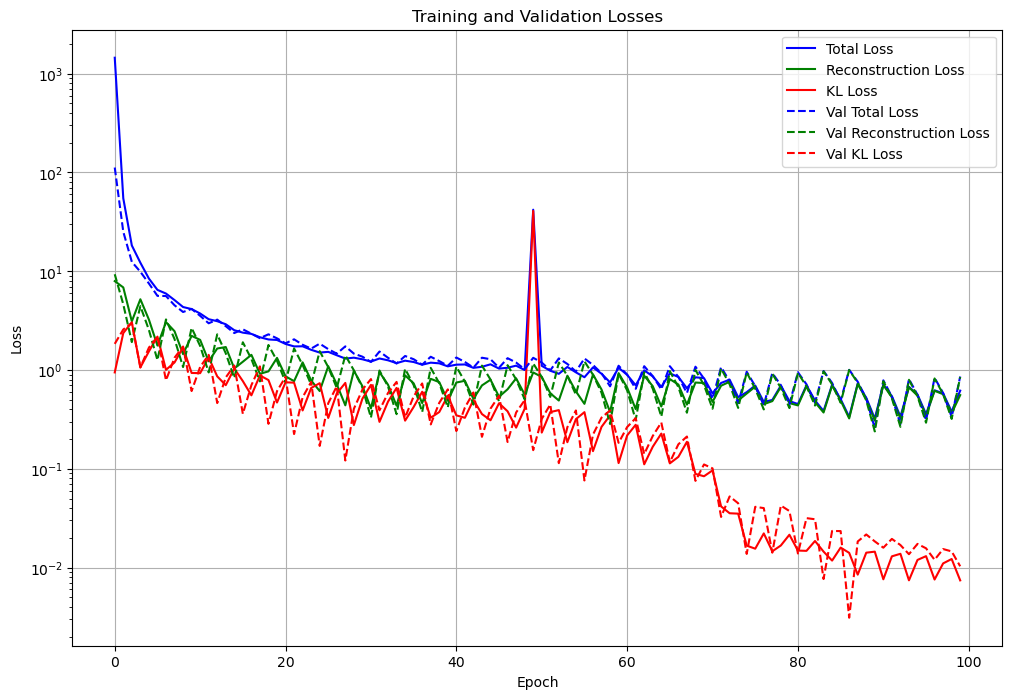

In [110]:

# Assuming 'history' is the object returned by your model.fit() call

# Extract the loss values
total_loss = history.history['loss']
reco_loss = history.history['reco_loss']
kl_loss = history.history['kl_loss']
val_total_loss = history.history['val_loss']
val_reco_loss = history.history['val_reco_loss']
val_kl_loss = history.history['val_kl_loss']

# Create a new figure
plt.figure(figsize=(12, 8))

# Plot training losses
plt.plot(total_loss, label='Total Loss', color='blue')
plt.plot(reco_loss, label='Reconstruction Loss', color='green')
plt.plot(kl_loss, label='KL Loss', color='red')

# Plot validation losses
plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')

# Customize the plot
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [19]:
def AD_score_KL(z_mean, z_log_var):
    kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    return kl_loss

def AD_score_CKL(z_mean, z_log_var):
    CKL = np.mean(z_mean**2)
    return CKL

def AD_score_MSE(s, p):
    mask = s != 0
    s1 = s * mask
    p1 = p * mask
    re_loss = np.mean((s1 - p1) ** 2)
    return re_loss

class Model_Evaluator:
    def __init__(
        self,
        model_path,
        background,
        br_weights,
        signal,
        signal_weights,
        input_dim,
        title="placeholder",
        save=False,
        labels=None,
    ):

        self.input_dim = input_dim
        vae_enc = Qmake_encoder_set_weights(input_dim, 32,16,3)
        vae_dec = Qmake_decoder_set_weights(input_dim, 32,16,3)
        # vae_disc = Qmake_discriminator(input_dim, h_dim_1, h_dim_2)
        discriminator_xz = Qmake_discriminator(input_dim+latent_dim, h_dim_1, h_dim_2, name="discriminator_xz")
        discriminator_xx = Qmake_discriminator(input_dim, h_dim_1, h_dim_2, name="discriminator_xx")
        discriminator_zz = Qmake_discriminator(latent_dim, h_dim_1, h_dim_2, name="discriminator_zz")
        self.model = VAE_GAN_Model(encoder, decoder, discriminator_xz, discriminator_xx, discriminator_zz)
        self.model.load_weights(model_path).expect_partial()
        self.encoder = self.model.get_layer("encoder")
        self.signal = signal
        self.background = background
        self.br_loss = []
        self.signal_loss = []
        self.background_outputs = []
        self.signal_outputs = []
        self.title = title
        self.saveplots = save
        self.labels = labels
        self.latent_info = []
        self.br_weights = br_weights
        self.signal_weights = signal_weights

    def calculate_loss(self, l_type):
        self.signal_loss = []
        self.br_loss = []
        br = self.background

        if l_type == "CKL":
            br_latent = np.array(self.encoder.predict(br))
            self.latent_info += [br_latent[0]]
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_CKL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))
                self.latent_info += [sg_latent[0]]
                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_CKL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]

        if l_type == "KL":
            br_latent = np.array(self.encoder.predict(br))
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_KL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))

                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_KL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]      

        if l_type == "MSE":
            br_predict = np.array(self.model.predict(br)["reconstruction"])
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_MSE(br[i], br_predict[i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_predict = np.array(self.model.predict(batch)["reconstruction"])
                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_MSE(batch[i], sg_predict[i])
                    l += [loss]

                sg_loss = l
                self.signal_loss += [sg_loss]

        return [self.br_loss, self.signal_loss]  

    def GetPerformance(self, show_plot=True):
        target_fpr = 1e-5
        tpr_at_target = []

        print(f"Number of signal losses: {len(self.signal_loss)}")
        print(f"Number of labels: {len(self.labels)}")
        print(f"Number of signal weights: {len(self.signal_weights)}")
        print(f"Length of br_loss: {len(self.br_loss)}")

        plt.figure(figsize=(10, 6))
        plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal")

        for j, batch in enumerate(self.signal_loss):
            print(f"Processing batch {j}")
            print(f"Batch length: {len(batch)}")
            print(f"Signal weight length: {len(self.signal_weights[j])}")

            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = np.concatenate([np.zeros(len(self.br_loss)), np.ones(len(batch))])
            ROC_data = np.concatenate((self.br_loss, batch))

            print(f"ROC_data shape: {ROC_data.shape}")
            print(f"truth shape: {truth.shape}")
            print(f"weights shape: {weights.shape}")

            try:
                fpr, tpr, _ = sk.roc_curve(truth, ROC_data, sample_weight=weights)
                auc = sk.roc_auc_score(truth, ROC_data)

                plt.plot(fpr, tpr, label=f"{self.labels[j]}: {auc:.3f}")

                idx = np.argmin(np.abs(fpr - target_fpr))
                tpr_at_target.append(tpr[idx])

                print(f"Successfully processed batch {j}")
            except Exception as e:
                print(f"Error processing batch {j}: {str(e)}")

        if show_plot:
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.xscale('log')
            plt.yscale('log')
            plt.title(f"{self.title} ROC")
            plt.vlines(target_fpr, 0, 1, colors="r", linestyles="dashed")
            plt.legend(loc="lower right")
            if self.saveplots:
                plt.savefig(
                    home_path+f"software_dev/plots/small/{self.title}_ROC.png",
                    format="png",
                    bbox_inches="tight",
                )
            plt.show()

        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        results = list(zip(self.labels, tpr_at_target))
        for label, tpr in results:
            print(f"{label}: {tpr*100:.6f}%")

        print(f"Number of results: {len(results)}")
        return results
    

    def histogram(self, bins, bg_only=False):
        plt.hist(
            self.br_loss,
            weights=self.br_weights,
            bins=bins,
            histtype="step",
            label="backround num_events:{}".format(len(self.br_loss)),
        )
        if not bg_only:
            for i, batch in enumerate(self.signal_loss):
                plt.hist(
                    batch,
                    weights=self.signal_weights[i],
                    bins=bins,
                    histtype="step",
                    label=str(self.labels[i]) + " num_events:{}".format(len(batch)),
                )
        plt.xlabel("loss")
        plt.ylabel("Frequency")
        plt.yscale("log")
        plt.title("{}_Hist".format(self.title))
        plt.legend()
        if self.saveplots == True:
            plt.savefig(
                home_path+"/analyses_plots/VAE_Varying_Plots/{}_Hist.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()


    def ROC(self, labels_to_plot=None):
        target_fpr = 1e-5
        tpr_at_target = []
        thresholds_at_target = []

        plt.plot(
            np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal"
        )
        for j, batch in enumerate(self.signal_loss):
            if labels_to_plot is None or self.labels[j] in labels_to_plot :
                sig_w = self.signal_weights[j]
                br_w = self.br_weights
                weights = np.concatenate((br_w, sig_w))
                truth = []
                for i in range(len(self.br_loss)):
                    truth += [0]
                for i in range(len(batch)):
                    truth += [1]
                ROC_data = np.concatenate((self.br_loss, batch))
                fpr, tpr, thresholds = sk.roc_curve(truth, ROC_data, sample_weight=weights)
                # auc=np.trapz(tpr,fpr)
                auc = sk.roc_auc_score(truth, ROC_data)
                plt.plot(fpr, tpr, label=self.labels[j] + ": " + str(round(auc, 3)))
                
                idx = np.argmin(np.abs(fpr - target_fpr))
                tpr_at_target.append(tpr[idx])
                thresholds_at_target.append(thresholds[idx])

        plt.xlabel("fpr")
        plt.xlim(1e-7, 1)
        plt.ylim(1e-7, 1)
        plt.semilogx()
        plt.ylabel("tpr")
        plt.semilogy()
        plt.title("{}_ROC".format(self.title))
        plt.vlines(10**-5, 0, 1, colors="r", linestyles="dashed")
        plt.legend(loc="lower right")
        if self.saveplots == True:
            plt.savefig(
                home_path+f"software_dev/plots/small/{self.title}_ROC.png",
                format="png",
                bbox_inches="tight",
            )
        # plt.show()
        
        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        for label, tpr, threshold in zip(self.labels, tpr_at_target, thresholds_at_target):
            print(f"{label}: {tpr*100:.6f}%, Threshold = {threshold:.6f}")


    def plot_anomaly_score_distribution(self):
        fig, ax = plt.subplots(figsize=(12, 8))
        bins = 10000
        # Determine the range for the bins
        all_scores = np.concatenate([self.br_loss] + self.signal_loss)
        min_score, max_score = 0.01, np.max(all_scores)
        bin_edges = np.linspace(min_score, max_score, bins + 1)

        # Plot background distribution
        br_weights = self.br_weights / np.sum(self.br_weights)  # Normalize weights
        counts, _, _ = ax.hist(self.br_loss, bins=bin_edges, weights=br_weights, 
                               histtype='step', label='Background',
                               color='black', density=True, linewidth=3)

        # Plot signal distributions
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.signal_loss)))
        for i, (signal_scores, signal_weights, label) in enumerate(zip(self.signal_loss, self.signal_weights, self.labels)):
            signal_weights = signal_weights / np.sum(signal_weights)  # Normalize weights
            ax.hist(signal_scores, bins=bin_edges, weights=signal_weights,
                    histtype='step', label=label, color=colors[i],
                    density=True, linewidth=2)

        ax.set_xlabel('Anomaly Score')
        ax.set_ylabel('Density')
        ax.set_title(f'{self.title} Anomaly Score Distribution')
        ax.legend()
        ax.grid(True, which='both', linestyle='--', alpha=0.7)

        ax.set_ylim(bottom=1e-4, top=10)

        # ax.set_xscale('log')
        # ax.set_yscale('log')

        if self.saveplots:
            plt.savefig(
                f"/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{self.title}_Anomaly_Score_Distribution_Histogram.png",
                format="png",
                bbox_inches="tight",
            )
        plt.show()

        # Calculate and print the mean anomaly score for each distribution
        print("\nMean Anomaly Scores:")
        print(f"Background: {np.average(self.br_loss, weights=self.br_weights):.6f}")
        for signal_scores, signal_weights, label in zip(self.signal_loss, self.signal_weights, self.labels):
            mean_score = np.average(signal_scores, weights=signal_weights)
            print(f"{label}: {mean_score:.6f}")

      

In [20]:

def plot_histogram(eval: Model_Evaluator, bins, bg_only=False, range=None, log_scale=False):
    plt.hist(
        eval.br_loss,
        weights=eval.br_weights,
        bins=bins,
        histtype="step",
        range=range,
        label="backround num_events:{}".format(len(eval.br_loss)),
    )
    if not bg_only:
        for i, batch in enumerate(eval.signal_loss):
            plt.hist(
                batch,
                weights=eval.signal_weights[i],
                bins=bins,
                histtype="step",
                range=range,
                label=str(eval.labels[i]) + " num_events:{}".format(len(batch)),
            )
    plt.xlabel("loss")
    plt.ylabel("Frequency")
    plt.yscale("log")
    plt.title("{}_Hist".format(eval.title))
    plt.legend()

    plt.xscale('log')
    plt.yscale('log')

    print("Mean Loss")
    print(f"Background: mean:{np.average(eval.br_loss, weights=eval.br_weights):.6f} std:{np.std(eval.br_loss):.6f}")
    for signal_scores, signal_weights, label in zip(eval.signal_loss, eval.signal_weights, eval.labels):
        mean_score = np.average(signal_scores, weights=signal_weights)
        print(f"{label}: mean: {mean_score:.6f}  std:{np.std(signal_scores):.6f}")

    # plt.show()

def get_threshold_from_ROC(eval: Model_Evaluator, target_fprs = [1e-5]):
    tpr_at_target = []
    thresholds_at_target = []

    for target_fpr in target_fprs:
        for j, batch in enumerate(eval.signal_loss):
            sig_w = eval.signal_weights[j]
            br_w = eval.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = []
            for i in range(len(eval.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((eval.br_loss, batch))
            if np.isnan(ROC_data).any() or np.isinf(ROC_data).any():
                print("NaN in ROC_data:", np.isnan(ROC_data).any())
                print("Inf in ROC_data:", np.isinf(ROC_data).any())
                return 

            fpr, tpr, thresholds = sk.roc_curve(truth, ROC_data, sample_weight=weights)
            break  # took this loop from ROC but really only need to do once
                
        idx = np.argmin(np.abs(fpr - target_fpr))
        tpr_at_target.append(tpr[idx])
        thresholds_at_target.append(thresholds[idx])

    # print(f"\nTPR at FPR = {target_fpr} for each channel:")
    # for label, tpr, threshold in zip(eval.labels, tpr_at_target, thresholds_at_target):
    #     print(f"{label}: {tpr*100:.6f}%, Threshold = {threshold:.6f}")
    return tpr_at_target, thresholds_at_target


def plot_ROC(eval: Model_Evaluator, labels_to_plot=None):
    target_fpr = 1e-5
    tpr_at_target = []
    thresholds_at_target = []

    plt.plot(
        np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal"
    )
    for j, batch in enumerate(eval.signal_loss):
        if labels_to_plot is None or eval.labels[j] in labels_to_plot :
            sig_w = eval.signal_weights[j]
            br_w = eval.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = []
            for i in range(len(eval.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((eval.br_loss, batch))
            if np.isnan(ROC_data).any() or np.isinf(ROC_data).any():
                print("NaN in ROC_data:", np.isnan(ROC_data).any())
                print("Inf in ROC_data:", np.isinf(ROC_data).any())
                return 

            fpr, tpr, thresholds = sk.roc_curve(truth, ROC_data, sample_weight=weights)
            # auc=np.trapz(tpr,fpr)
            auc = sk.roc_auc_score(truth, ROC_data)
            plt.plot(fpr, tpr, label=eval.labels[j] + ": " + str(round(auc, 3)))
            
            idx = np.argmin(np.abs(fpr - target_fpr))
            tpr_at_target.append(tpr[idx])
            thresholds_at_target.append(thresholds[idx])

    plt.xlabel("fpr")
    plt.xlim(1e-7, 1)
    plt.ylim(1e-7, 1)
    plt.semilogx()
    plt.ylabel("tpr")
    plt.semilogy()
    plt.title("{}_ROC".format(eval.title))
    plt.vlines(10**-5, 0, 1, colors="r", linestyles="dashed")
    plt.legend(loc="lower right")
    # plt.show()
    
    print(f"\nTPR at FPR = {target_fpr} for each channel:")
    for label, tpr, threshold in zip(eval.labels, tpr_at_target, thresholds_at_target):
        print(f"{label}: {tpr*100:.6f}%, Threshold = {threshold:.6f}")

def plot_anomaly_score_distribution(eval, bins=1000, range=None):
    fig, ax = plt.subplots(figsize=(12, 8))
    # Determine the range for the bins
    all_scores = np.concatenate([eval.br_loss] + eval.signal_loss)
    min_score, max_score = 0.01, np.max(all_scores)
    # bin_edges = np.linspace(min_score, max_score, bins + 1)
    # bin_edges = np.logspace(np.log10(min_score), np.log10(max_score), bins + 1)
    min_range, max_range = range
    bin_edges = np.logspace(np.log10(min_range), np.log10(max_range), bins + 1)


    # Plot background distribution
    br_weights = eval.br_weights / np.sum(eval.br_weights)  # Normalize weights
    ax.hist(eval.br_loss, 
            bins=bin_edges, 
            weights=br_weights, 
            histtype='step', 
            label='Background',
            color='black', 
            density=True,
            range=range)

    # Plot signal distributions
    colors = plt.cm.rainbow(np.linspace(0, 1, len(eval.signal_loss)))
    for i, (signal_scores, signal_weights, label) in enumerate(zip(eval.signal_loss, eval.signal_weights, eval.labels)):
        signal_weights = signal_weights / np.sum(signal_weights)  # Normalize weights
        ax.hist(signal_scores, 
                bins=bin_edges, 
                weights=signal_weights,
                histtype='step', 
                label=label, 
                color=colors[i],
                density=True, 
                range=range)

    ax.set_xlabel('Anomaly Score')
    ax.set_ylabel('Density')
    ax.set_title(f'{eval.title} Anomaly Score Distribution')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', alpha=0.7)

    ax.set_ylim(bottom=1e-4, top=1e3)
    ax.set_xlim(range)
    ax.set_xscale('log')
    ax.set_yscale('log')

    # plt.show()

    # Calculate and print the mean anomaly score for each distribution
    print("\nMean Anomaly Scores:")
    print(f"Background: {np.average(eval.br_loss, weights=eval.br_weights):.6f}")
    for signal_scores, signal_weights, label in zip(eval.signal_loss, eval.signal_weights, eval.labels):
        mean_score = np.average(signal_scores, weights=signal_weights)
        print(f"{label}: {mean_score:.6f}")


In [21]:
gamma_values = np.array([0.01, 0.1, 1.0, 10.0, 100.0, 1000.0])  # List of gamma values to try
iters = 10
loss_arr = np.zeros((6, iters))
reco_loss_arr = np.zeros((6, iters))
models_array = np.empty((6, iters), dtype=object)
history_array = np.empty((6, iters), dtype=object)


Evaluating model from path: /fs/ddn/sdf/group/atlas/d/lizhx/software_dev/trained_models/adversarial_full/gamma1e00/iter_0/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 15s 1ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)
Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data sha

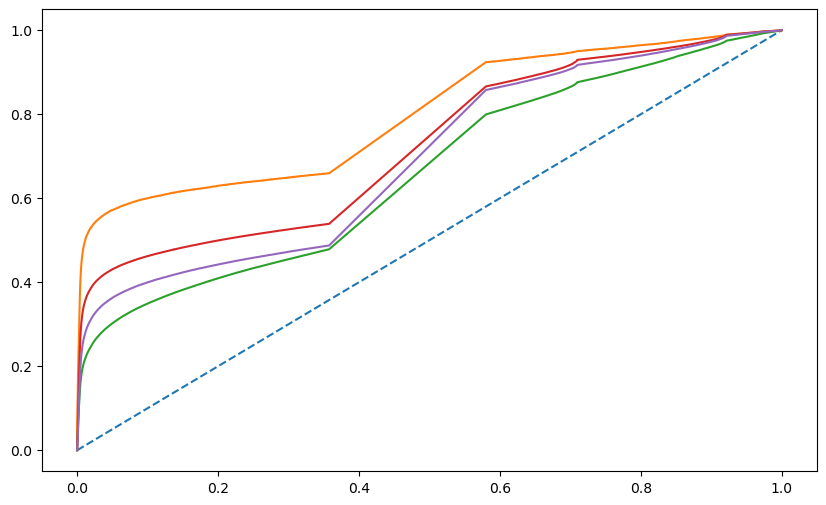

Evaluating model from path: /fs/ddn/sdf/group/atlas/d/lizhx/software_dev/trained_models/adversarial_full/gamma1e00/iter_1/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 15s 1ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)
Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data sha

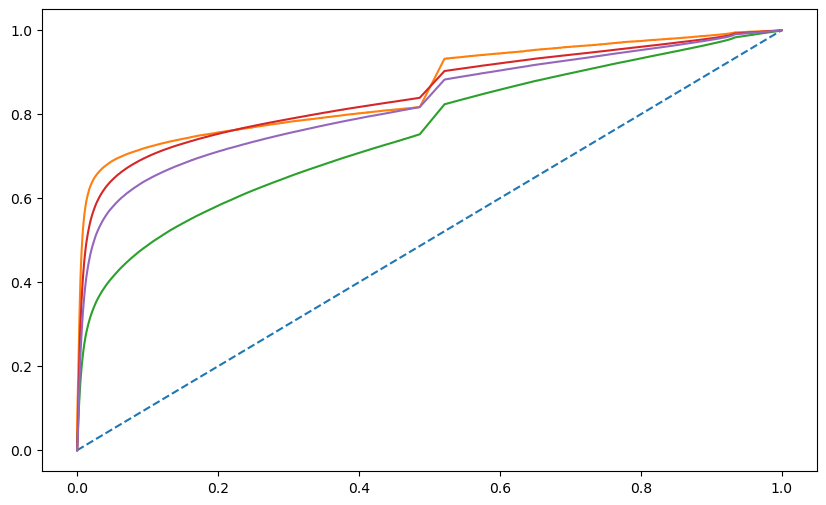

Evaluating model from path: /fs/ddn/sdf/group/atlas/d/lizhx/software_dev/trained_models/adversarial_full/gamma1e00/iter_2/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 15s 1ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)
Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data sha

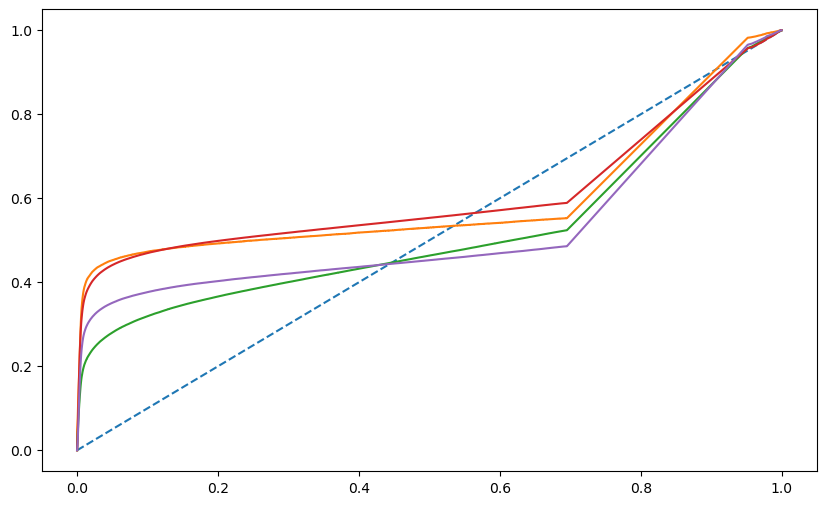

Evaluating model from path: /fs/ddn/sdf/group/atlas/d/lizhx/software_dev/trained_models/adversarial_full/gamma1e00/iter_3/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 25s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)
Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data sha

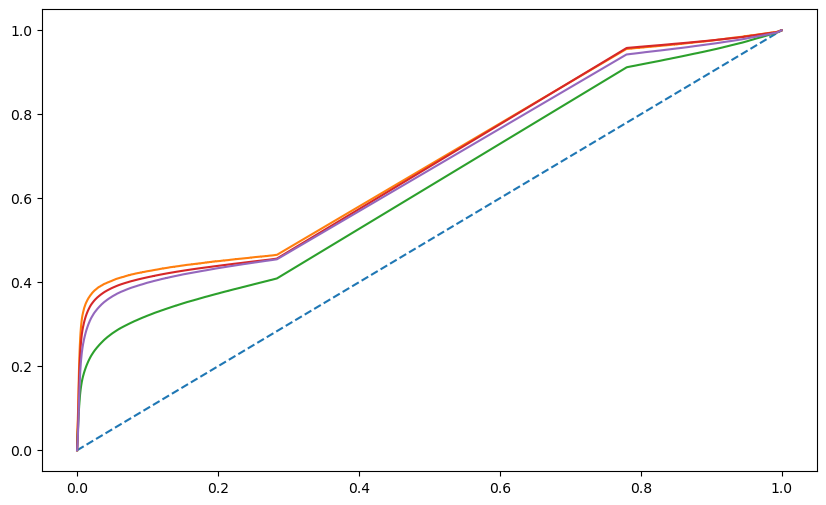

Evaluating model from path: /fs/ddn/sdf/group/atlas/d/lizhx/software_dev/trained_models/adversarial_full/gamma1e00/iter_4/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 34s 3ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)
Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data sha

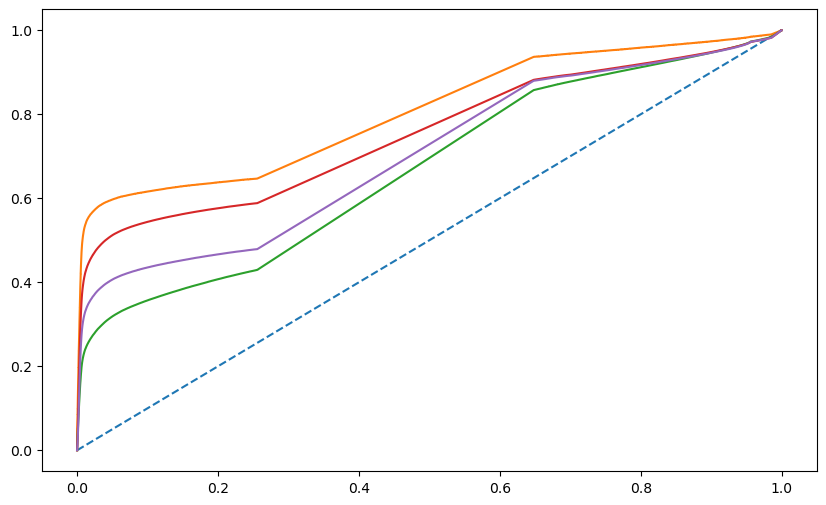

Evaluating model from path: /fs/ddn/sdf/group/atlas/d/lizhx/software_dev/trained_models/adversarial_full/gamma1e00/iter_5/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 15s 1ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)
Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data sha

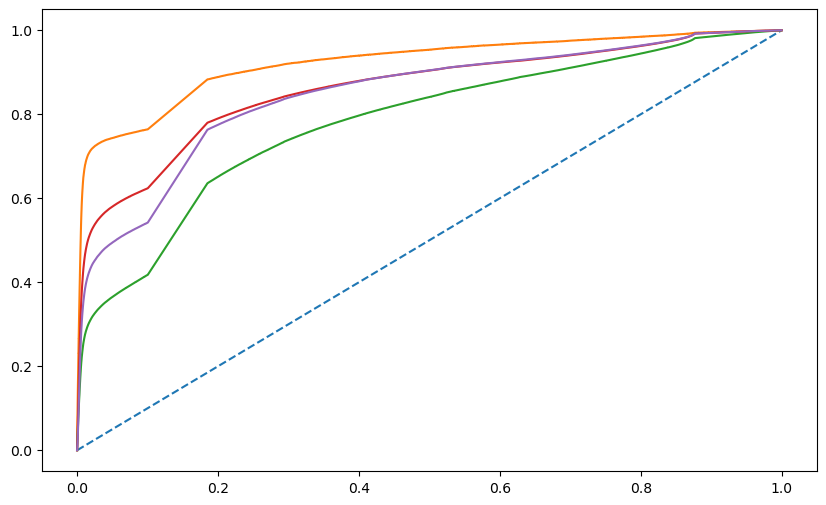

Evaluating model from path: /fs/ddn/sdf/group/atlas/d/lizhx/software_dev/trained_models/adversarial_full/gamma1e00/iter_6/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 15s 1ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)
Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data sha

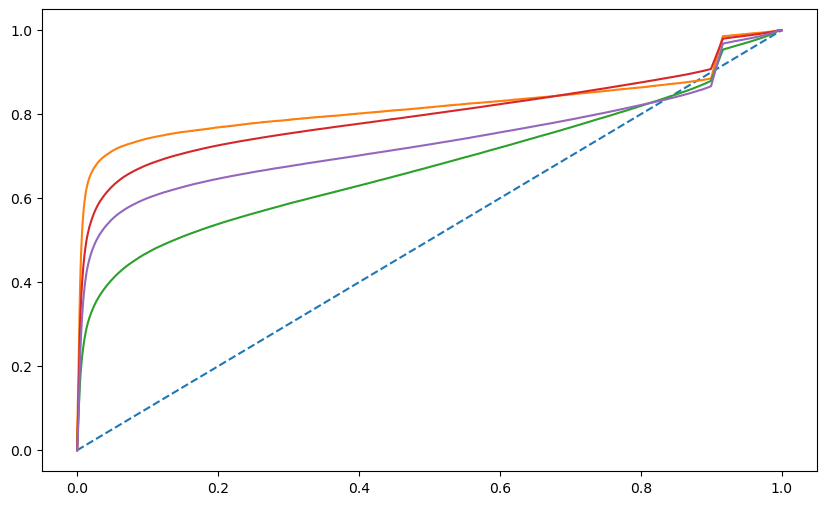

Evaluating model from path: /fs/ddn/sdf/group/atlas/d/lizhx/software_dev/trained_models/adversarial_full/gamma1e00/iter_7/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 16s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)
Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data sha

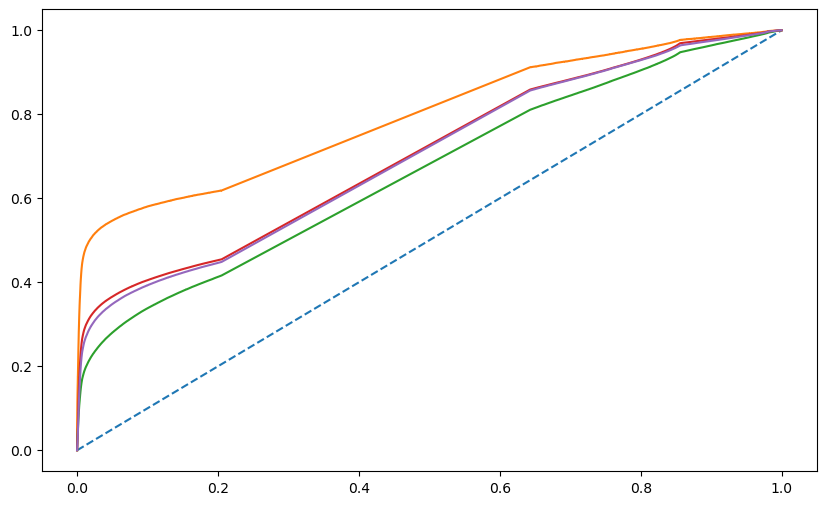

Evaluating model from path: /fs/ddn/sdf/group/atlas/d/lizhx/software_dev/trained_models/adversarial_full/gamma1e00/iter_8/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 18s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)
Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data sha

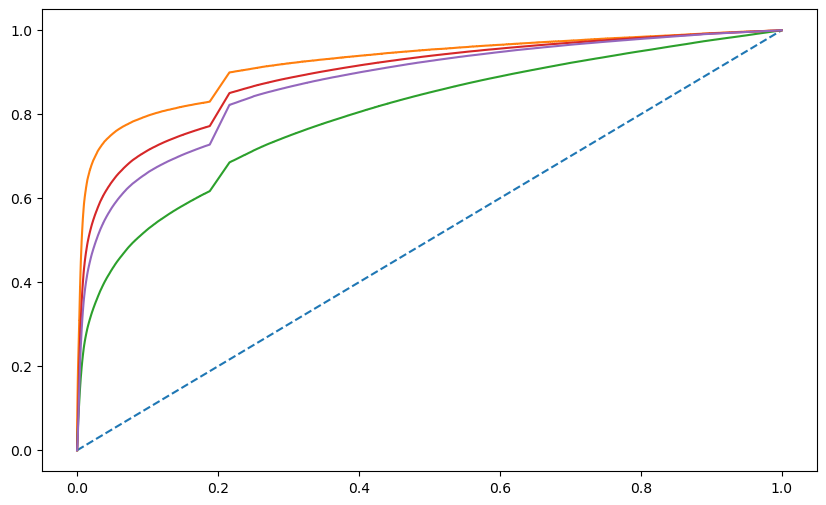

Evaluating model from path: /fs/ddn/sdf/group/atlas/d/lizhx/software_dev/trained_models/adversarial_full/gamma1e00/iter_9/
Model_Evaluator instance created successfully
Calculating losses...
10642/10642 [==============================] - 17s 2ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 800000
Processing batch 0
Batch length: 55969
Signal weight length: 55969
ROC_data shape: (855969,)
truth shape: (855969,)
weights shape: (855969,)
Successfully processed batch 0
Processing batch 1
Batch length: 691283
Signal weight length: 691283
ROC_data shape: (1491283,)
truth shape: (1491283,)
weights shape: (1491283,)
Successfully processed batch 1
Processing batch 2
Batch length: 760272
Signal weight length: 760272
ROC_data shape: (1560272,)
truth shape: (1560272,)
weights shape: (1560272,)
Successfully processed batch 2
Processing batch 3
Batch length: 340544
Signal weight length: 340544
ROC_data sha

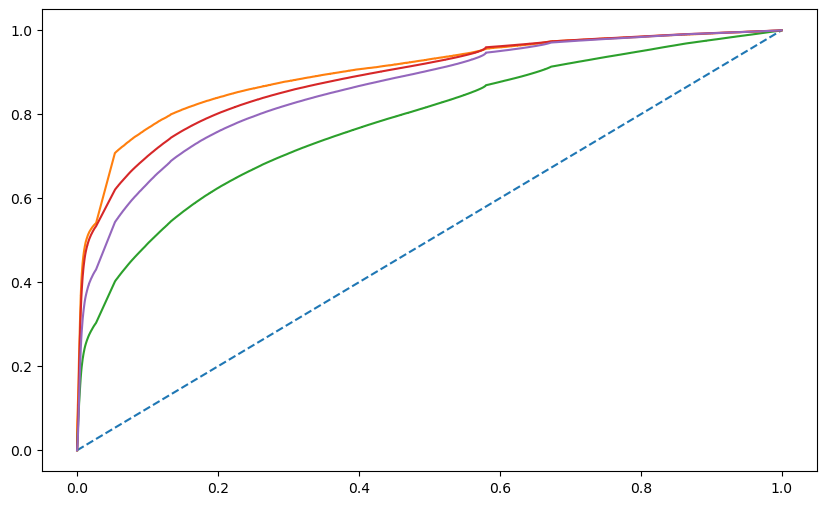

Final channel results: {'Ato4l': [[0.04497132341117404, 0.036663152816737835, 0.023691686469295502, 0.020904429237613677, 0.02640747556683164, 0.01779556540227626, 0.028408583322910897, 0.04029016062463149, 0.03861065947220783, 0.036270078078936556], [], [], [], [], []], 'hToTauTau': [[0.0006437305705478075, 0.0007363120458625484, 0.00042240298112350514, 0.0005193242130936245, 0.0006712156960318712, 0.0006220317872709151, 0.0004296359088824693, 0.0006914678937569707, 0.0005916534906832658, 0.0005844205629243017], [], [], [], [], []], 'hChToTauNu': [[0.0005747942841509354, 0.0006221457583601658, 0.0003919649809541848, 0.00042484794915503924, 0.0005590104594145253, 0.0004314245427952101, 0.0003393522318328177, 0.0006116232085358924, 0.0005905781088873456, 0.0005576951406864912], [], [], [], [], []], 'leptoquark': [[0.0006665805299755685, 0.0006988817891373802, 0.0003699962413080248, 0.00038174215373050176, 0.0005080107122721293, 0.0004169798909979327, 0.0004316622815260289, 0.00063721574

In [22]:
results = []
signal_labels = ["Ato4l",
                "hToTauTau",
                "hChToTauNu",
                "leptoquark"
                ]
signal_data = [Ato4l_data,
               hToTauTau_data,
               hChToTauNu_data,
               leptoquark_data
               ]
# models_to_eval = [
#       (0,11),(0,12)
# ]


evals = np.empty((6, iters), dtype=object)
channel_results = {}    # dict with key:channel value:channel[gamma][iter] 

for i in range(1):
    for j in range(iters) : 
# for i,j in models_to_eval : 
# for j in range(iters) : 
        try:
            # model_path = home_path+f'software_dev/trained_models/adversarial/toyGAN_full/'
            model_path = home_path+f'software_dev/trained_models/adversarial_full/gamma1e00/iter_{j}/'
            # model_path = home_path+f'software_dev/trained_models/gamma_tuning/gamma_in_beta/iter_{j}/'

            print(f"Evaluating model from path: {model_path}")
            evaluation = Model_Evaluator(model_path,
                                X_test,
                                np.ones(len(X_test)),
                                signal_data,
                                [np.ones(len(Ato4l_data)),
                                        np.ones(len(hToTauTau_data)),
                                        np.ones(len(hChToTauNu_data)),
                                        np.ones(len(leptoquark_data))],
                                input_dim = X_test.shape[1],
                                title=f'ALAD Model gamma 100 iter {j}',
                                # title=f'VAE-GAN Model iter {j}',
                                save = False,
                                labels = signal_labels)
            
            print("Model_Evaluator instance created successfully")
            
            print("Calculating losses...")
            evaluation.calculate_loss('CKL')
            print("Losses calculated")
            
            print("Getting performance...")
            result = evaluation.GetPerformance(show_plot=False)
            print(f"GetPerformance() returned: {result}")
            
            if not result:
                print(f"Warning: GetPerformance() returned an empty result for model {j}")
            else:
                evals[i][j] = evaluation
                # evals[0][j] = evaluation
                for channel, tpr in result:
                    if channel not in channel_results:
                        channel_results[channel] = [[] for _ in range(6)]
                    channel_results[channel][i].append(tpr)
                    # channel_results[channel][0].append(tpr)
        
        except Exception as e:
            print(f"An error occurred while evaluating model {j}:")
            print(traceback.format_exc())
                
        plt.show()


print("Final channel results:", channel_results)


TPR at FPR = 1e-05 for each channel:
Ato4l: 4.497132%, Threshold = 174.830551
hToTauTau: 0.064373%, Threshold = 174.830551
hChToTauNu: 0.057479%, Threshold = 174.830551
leptoquark: 0.066658%, Threshold = 174.830551


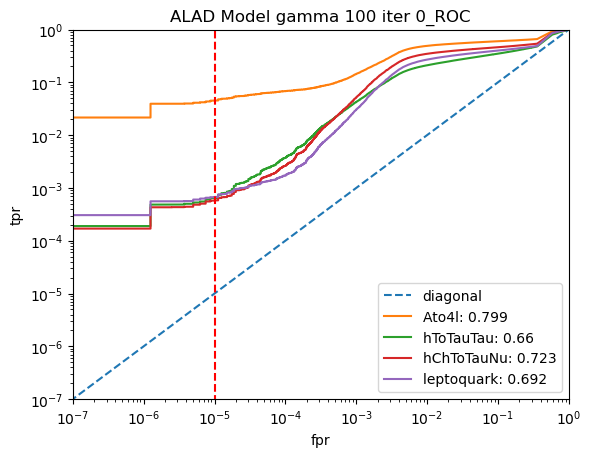


Mean Anomaly Scores:
Background: 0.016347
Ato4l: 69.634019
hToTauTau: 1.071551
hChToTauNu: 1.175430
leptoquark: 1.154484


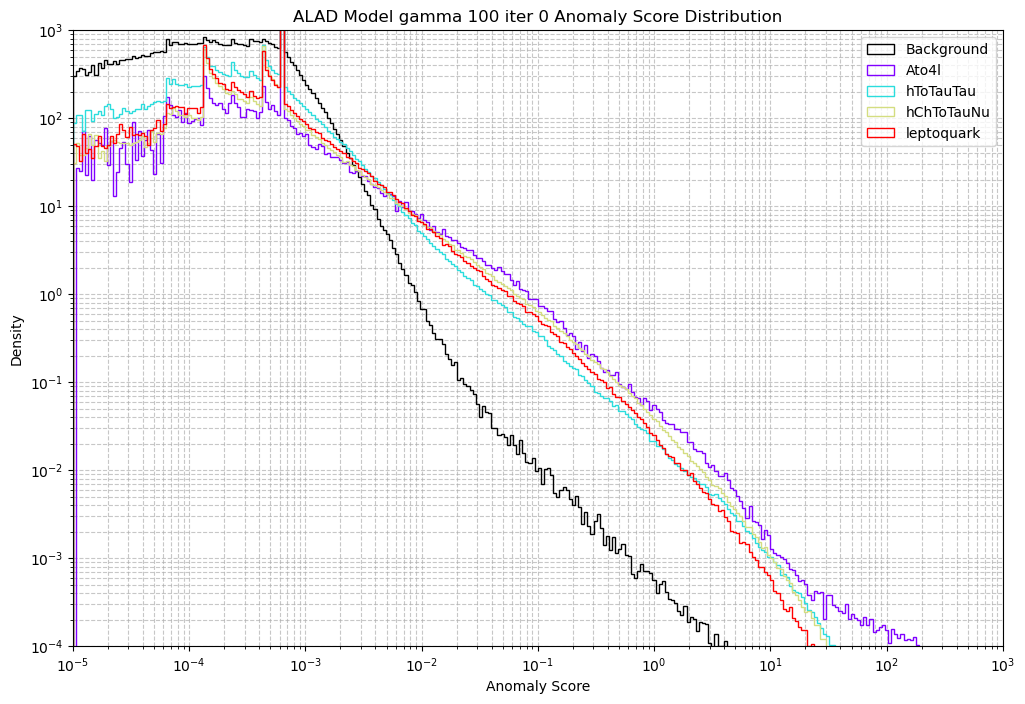


TPR at FPR = 1e-05 for each channel:
Ato4l: 3.666315%, Threshold = 85.383270
hToTauTau: 0.073631%, Threshold = 85.383270
hChToTauNu: 0.062215%, Threshold = 85.383270
leptoquark: 0.069888%, Threshold = 85.383270


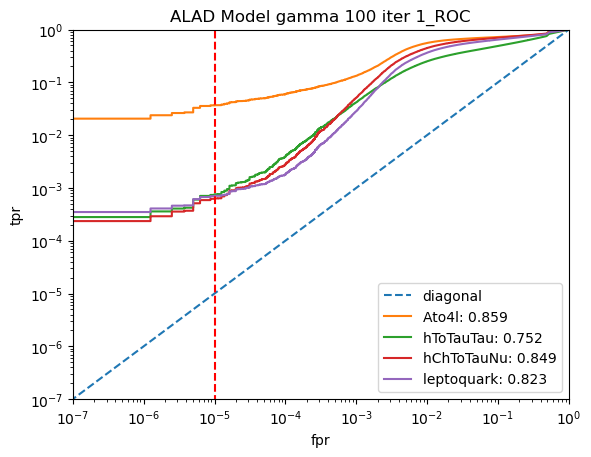


Mean Anomaly Scores:
Background: 0.015149
Ato4l: 78.129989
hToTauTau: 1.240932
hChToTauNu: 1.292504
leptoquark: 1.508201


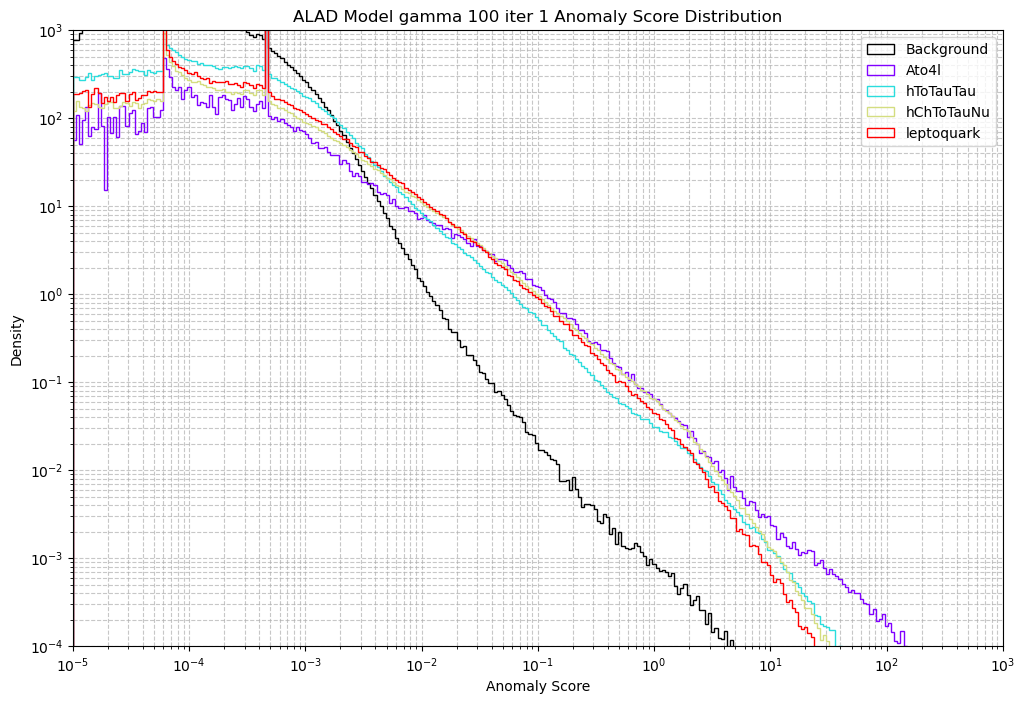


TPR at FPR = 1e-05 for each channel:
Ato4l: 2.369169%, Threshold = 118.415985
hToTauTau: 0.042240%, Threshold = 118.415985
hChToTauNu: 0.039196%, Threshold = 118.415985
leptoquark: 0.037000%, Threshold = 118.415985


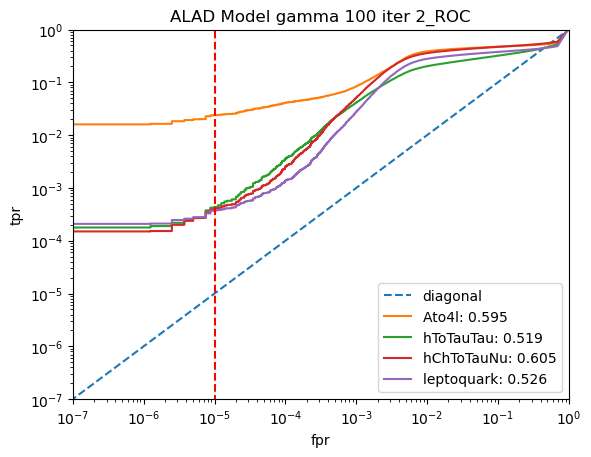


Mean Anomaly Scores:
Background: 0.014554
Ato4l: 597.735099
hToTauTau: 6.114557
hChToTauNu: 5.365804
leptoquark: 8.718416


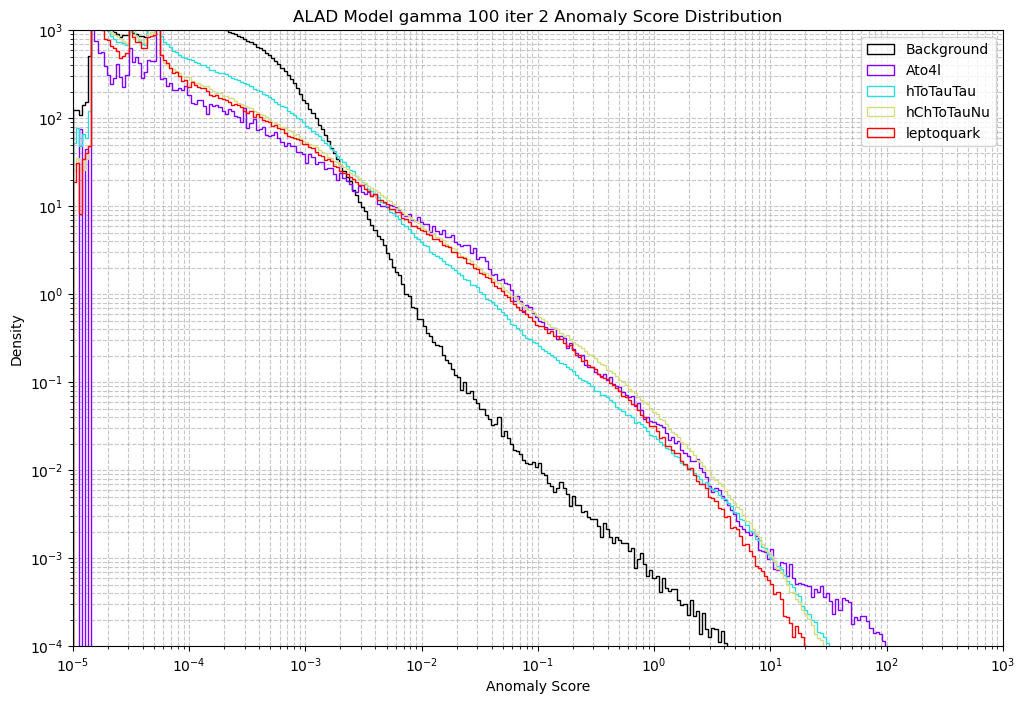


TPR at FPR = 1e-05 for each channel:
Ato4l: 2.090443%, Threshold = 108.894592
hToTauTau: 0.051932%, Threshold = 108.894592
hChToTauNu: 0.042485%, Threshold = 108.894592
leptoquark: 0.038174%, Threshold = 108.894592


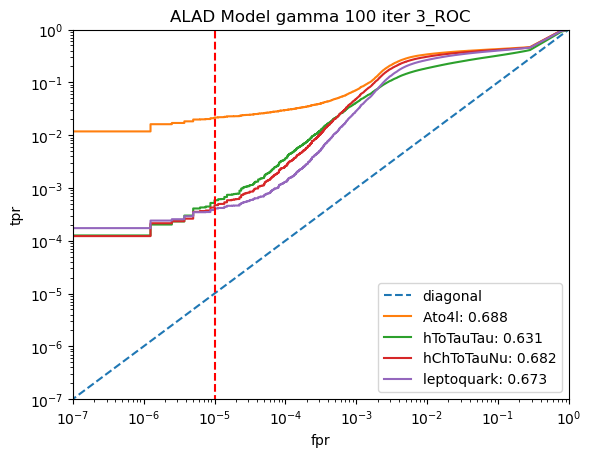


Mean Anomaly Scores:
Background: 0.016146
Ato4l: 66.597315
hToTauTau: 1.022837
hChToTauNu: 1.520188
leptoquark: 1.475210


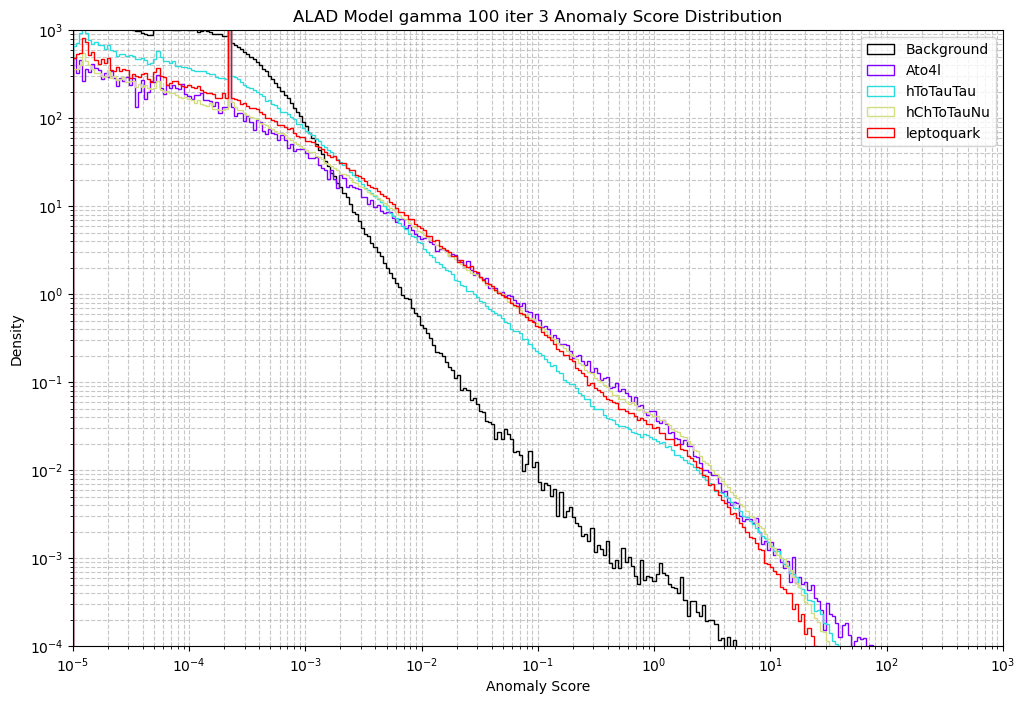


TPR at FPR = 1e-05 for each channel:
Ato4l: 2.640748%, Threshold = 109.551857
hToTauTau: 0.067122%, Threshold = 109.551857
hChToTauNu: 0.055901%, Threshold = 109.551857
leptoquark: 0.050801%, Threshold = 109.551857


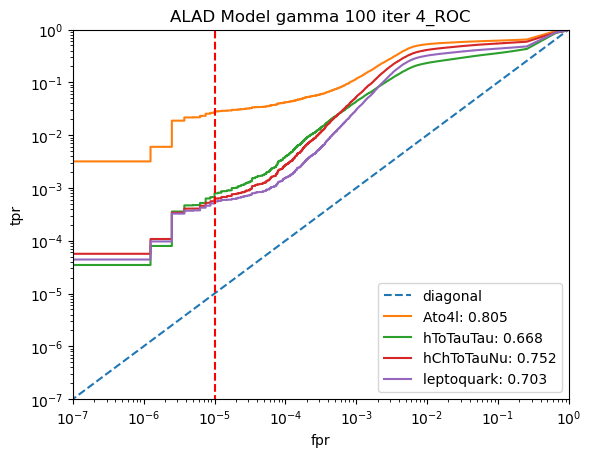


Mean Anomaly Scores:
Background: 0.019230
Ato4l: 41.882028
hToTauTau: 1.013702
hChToTauNu: 1.233026
leptoquark: 0.888435


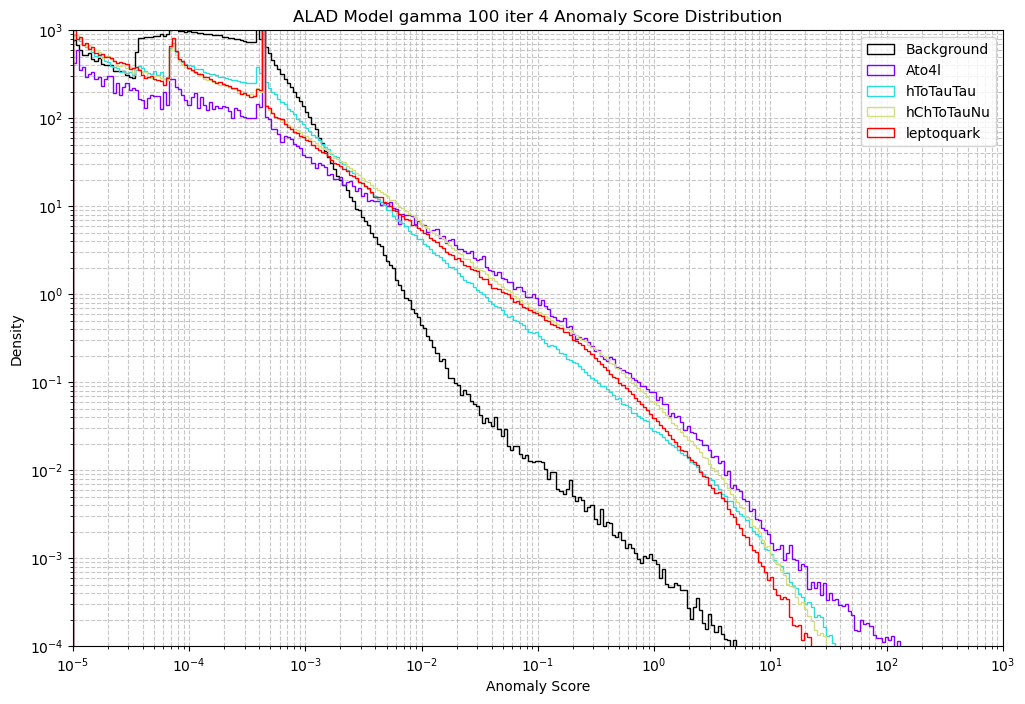


TPR at FPR = 1e-05 for each channel:
Ato4l: 1.779557%, Threshold = 125.091095
hToTauTau: 0.062203%, Threshold = 125.091095
hChToTauNu: 0.043142%, Threshold = 125.091095
leptoquark: 0.041698%, Threshold = 125.091095


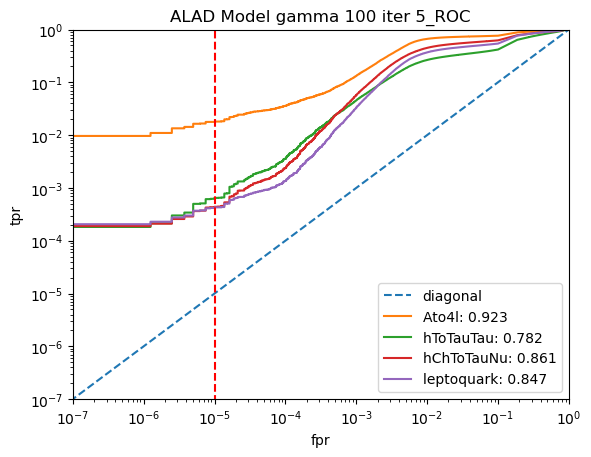


Mean Anomaly Scores:
Background: 0.015963
Ato4l: 228.487743
hToTauTau: 4.312113
hChToTauNu: 6.392161
leptoquark: 5.413229


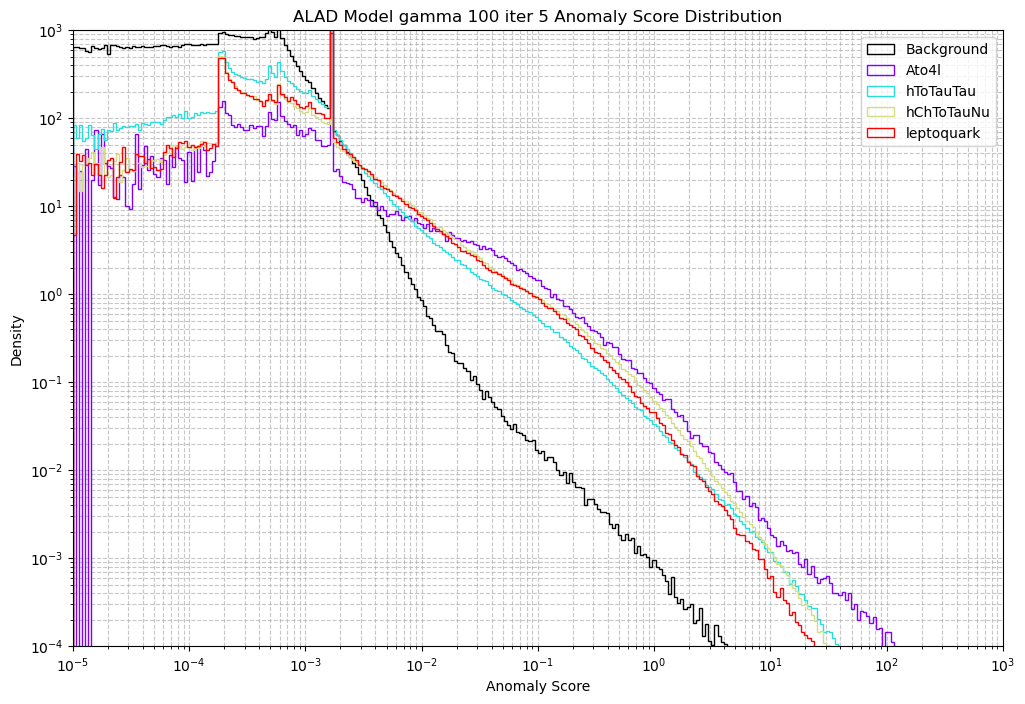


TPR at FPR = 1e-05 for each channel:
Ato4l: 2.840858%, Threshold = 130.966019
hToTauTau: 0.042964%, Threshold = 130.362457
hChToTauNu: 0.033935%, Threshold = 130.966019
leptoquark: 0.043166%, Threshold = 130.362457


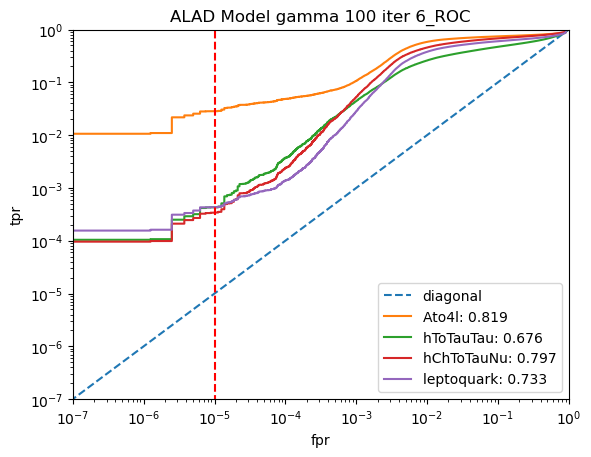


Mean Anomaly Scores:
Background: 0.019555
Ato4l: 48.322725
hToTauTau: 1.102466
hChToTauNu: 1.061177
leptoquark: 0.995242


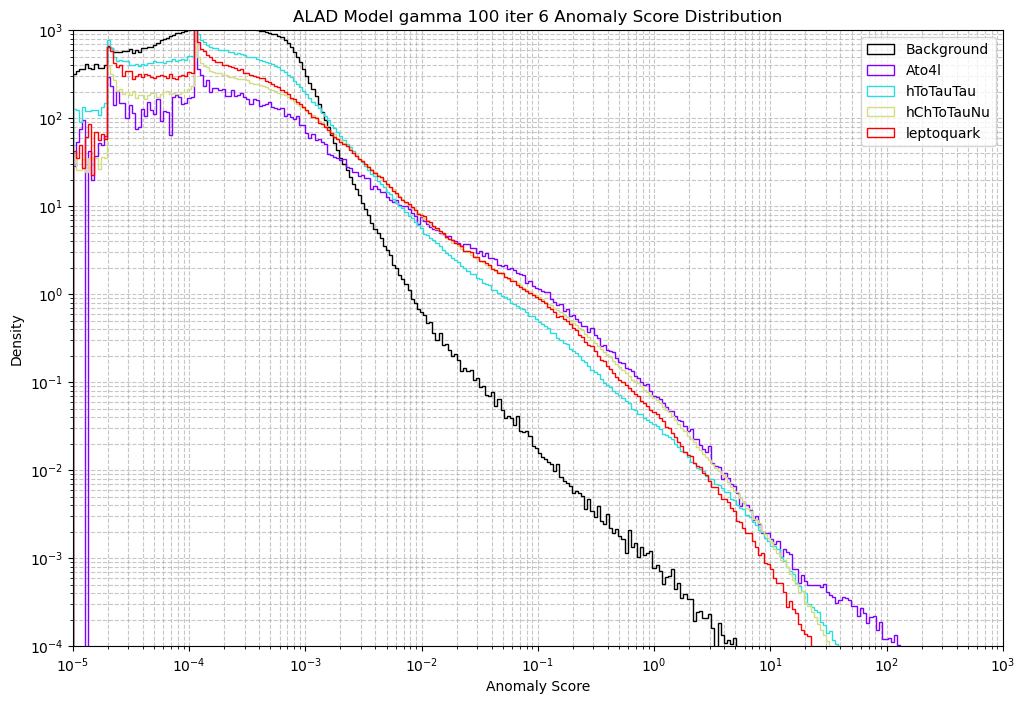


TPR at FPR = 1e-05 for each channel:
Ato4l: 4.029016%, Threshold = 105.308418
hToTauTau: 0.069147%, Threshold = 105.308418
hChToTauNu: 0.061162%, Threshold = 105.308418
leptoquark: 0.063722%, Threshold = 105.308418


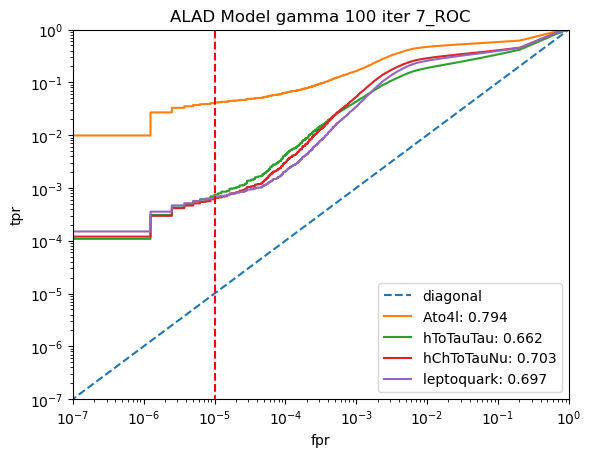


Mean Anomaly Scores:
Background: 0.013084
Ato4l: 75.146694
hToTauTau: 1.585945
hChToTauNu: 2.118677
leptoquark: 1.625305


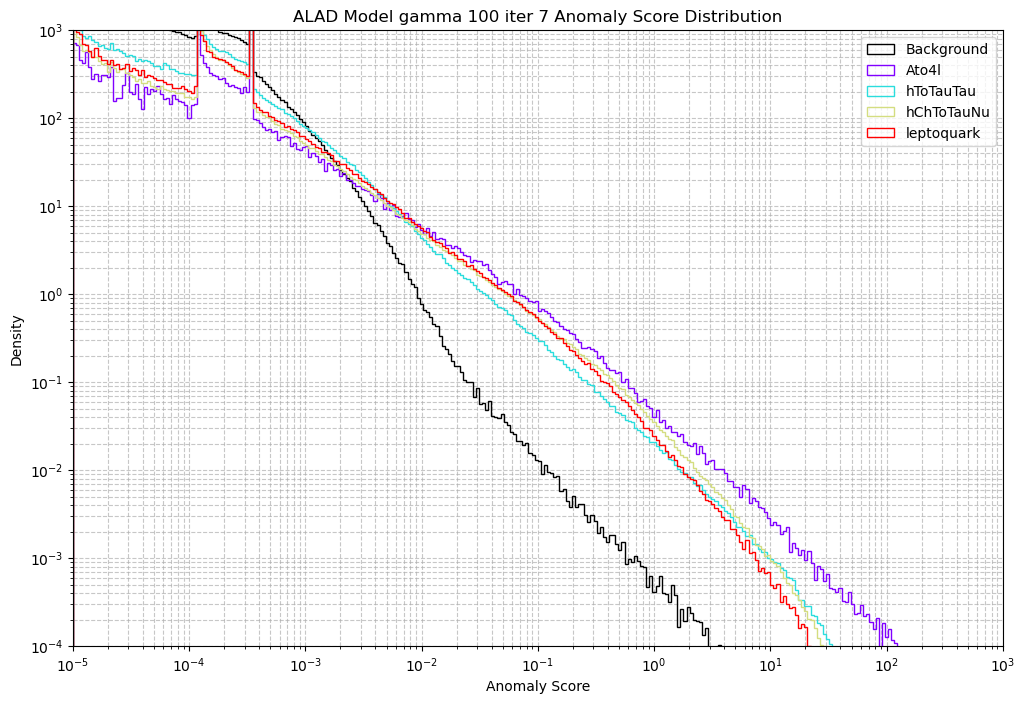


TPR at FPR = 1e-05 for each channel:
Ato4l: 3.861066%, Threshold = 135.500122
hToTauTau: 0.059165%, Threshold = 135.500122
hChToTauNu: 0.059058%, Threshold = 135.500122
leptoquark: 0.065483%, Threshold = 135.224503


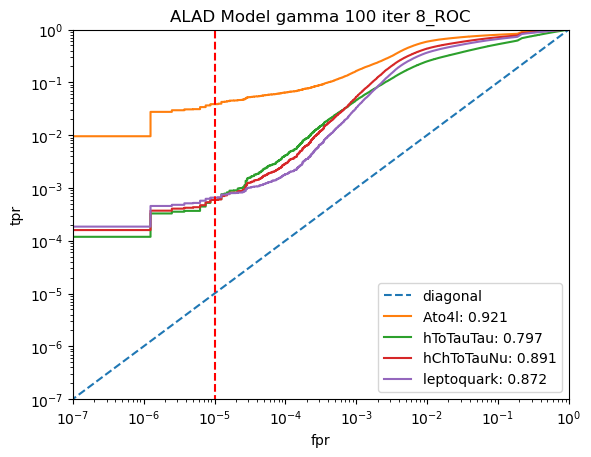


Mean Anomaly Scores:
Background: 0.018647
Ato4l: 53.684662
hToTauTau: 1.271093
hChToTauNu: 1.487373
leptoquark: 1.238666


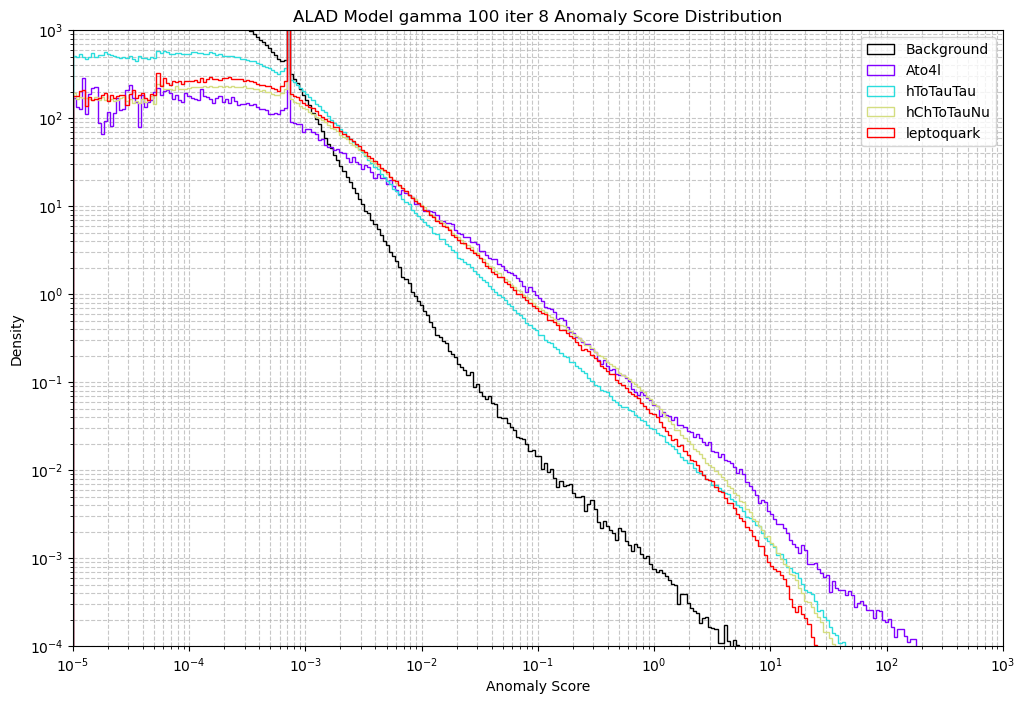


TPR at FPR = 1e-05 for each channel:
Ato4l: 3.627008%, Threshold = 100.111565
hToTauTau: 0.058442%, Threshold = 100.111565
hChToTauNu: 0.055770%, Threshold = 100.111565
leptoquark: 0.060198%, Threshold = 100.111565


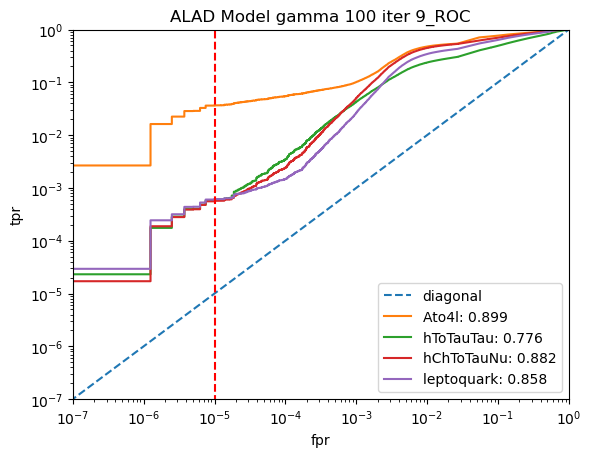


Mean Anomaly Scores:
Background: 0.065165
Ato4l: 331.234606
hToTauTau: 3.692056
hChToTauNu: 3.383657
leptoquark: 4.944747


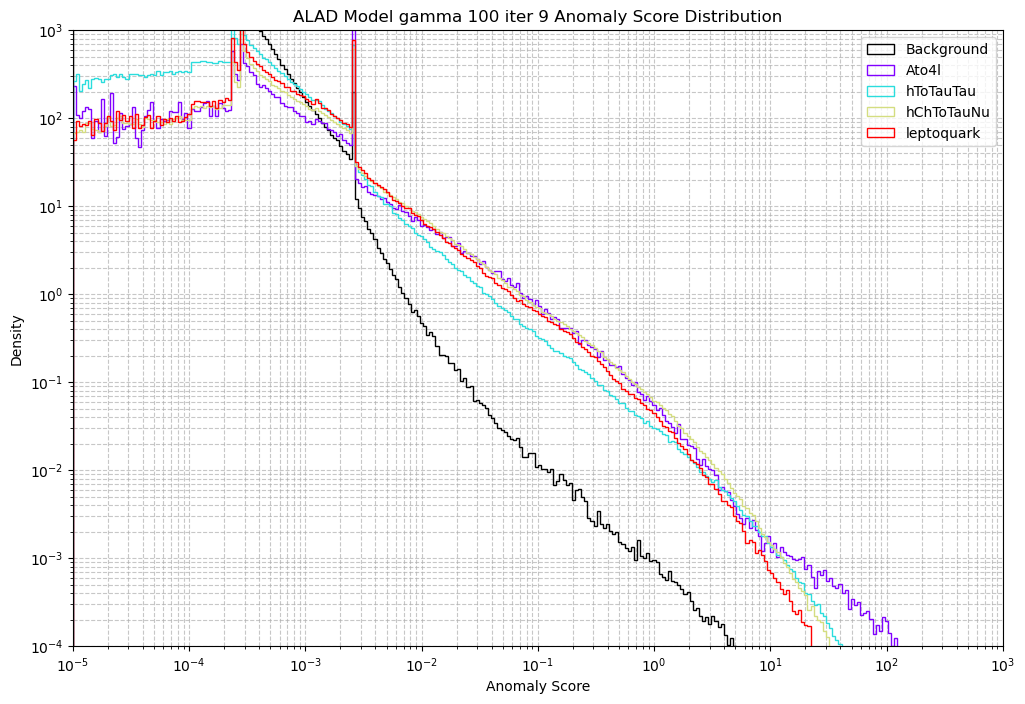

In [24]:
# gamma 1
for i in range(1):
    for j in range(iters) : 
        curr_eval = evals[i][j]
        if curr_eval is not None:
            plot_ROC(curr_eval)
            plt.show()
            plot_anomaly_score_distribution(curr_eval, bins=300, range=(1e-5, 1e3))
            plt.show()



TPR at FPR = 1e-05 for each channel:
Ato4l: 4.497132%, Threshold = 174.830551
hToTauTau: 0.064373%, Threshold = 174.830551
hChToTauNu: 0.057479%, Threshold = 174.830551
leptoquark: 0.066658%, Threshold = 174.830551


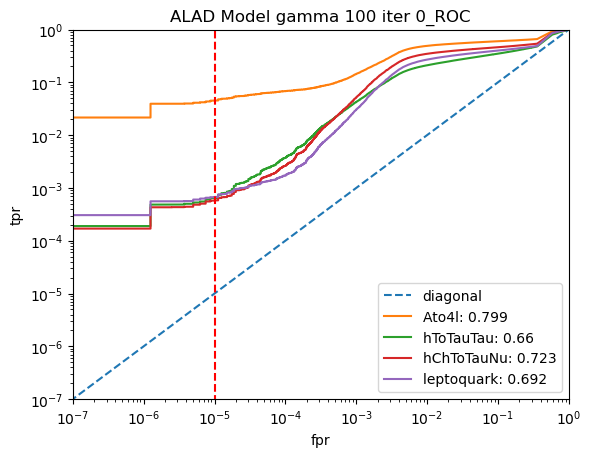


Mean Anomaly Scores:
Background: 0.016347
Ato4l: 69.634019
hToTauTau: 1.071551
hChToTauNu: 1.175430
leptoquark: 1.154484


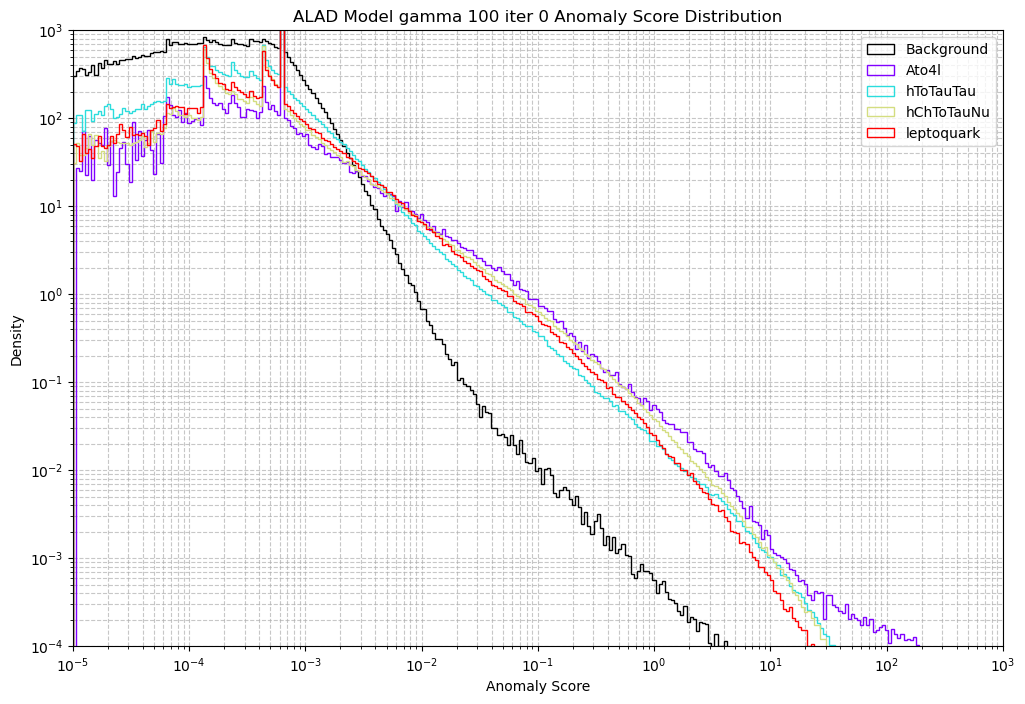


TPR at FPR = 1e-05 for each channel:
Ato4l: 3.666315%, Threshold = 85.383270
hToTauTau: 0.073631%, Threshold = 85.383270
hChToTauNu: 0.062215%, Threshold = 85.383270
leptoquark: 0.069888%, Threshold = 85.383270


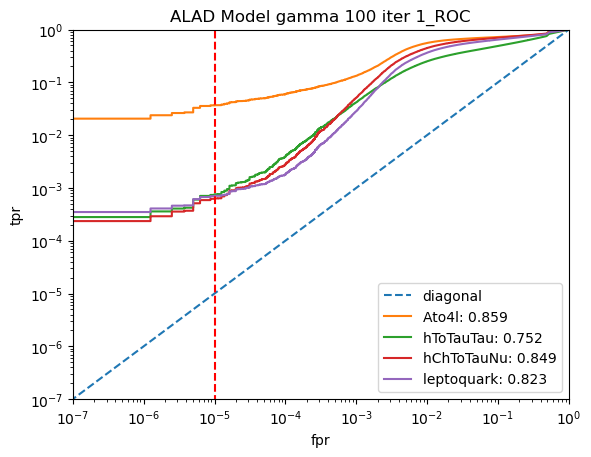


Mean Anomaly Scores:
Background: 0.015149
Ato4l: 78.129989
hToTauTau: 1.240932
hChToTauNu: 1.292504
leptoquark: 1.508201


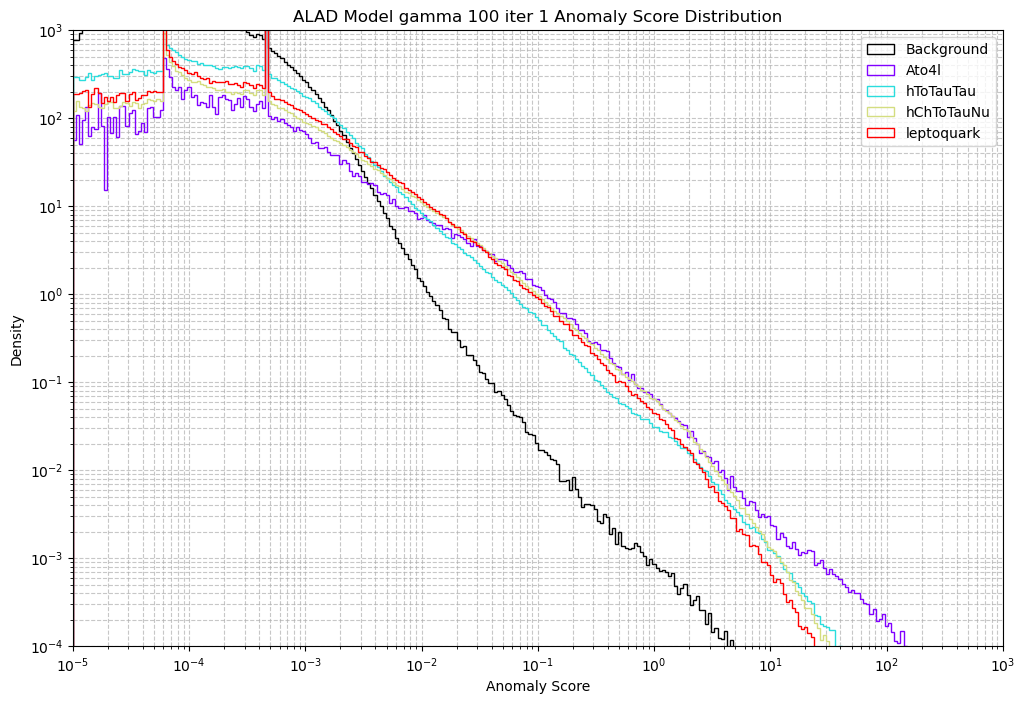


TPR at FPR = 1e-05 for each channel:
Ato4l: 2.369169%, Threshold = 118.415985
hToTauTau: 0.042240%, Threshold = 118.415985
hChToTauNu: 0.039196%, Threshold = 118.415985
leptoquark: 0.037000%, Threshold = 118.415985


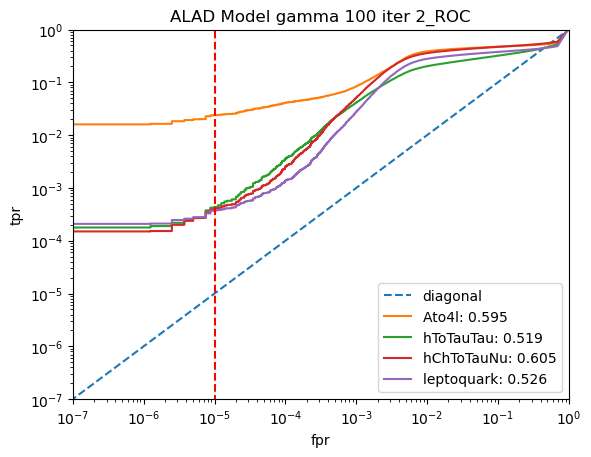


Mean Anomaly Scores:
Background: 0.014554
Ato4l: 597.735099
hToTauTau: 6.114557
hChToTauNu: 5.365804
leptoquark: 8.718416


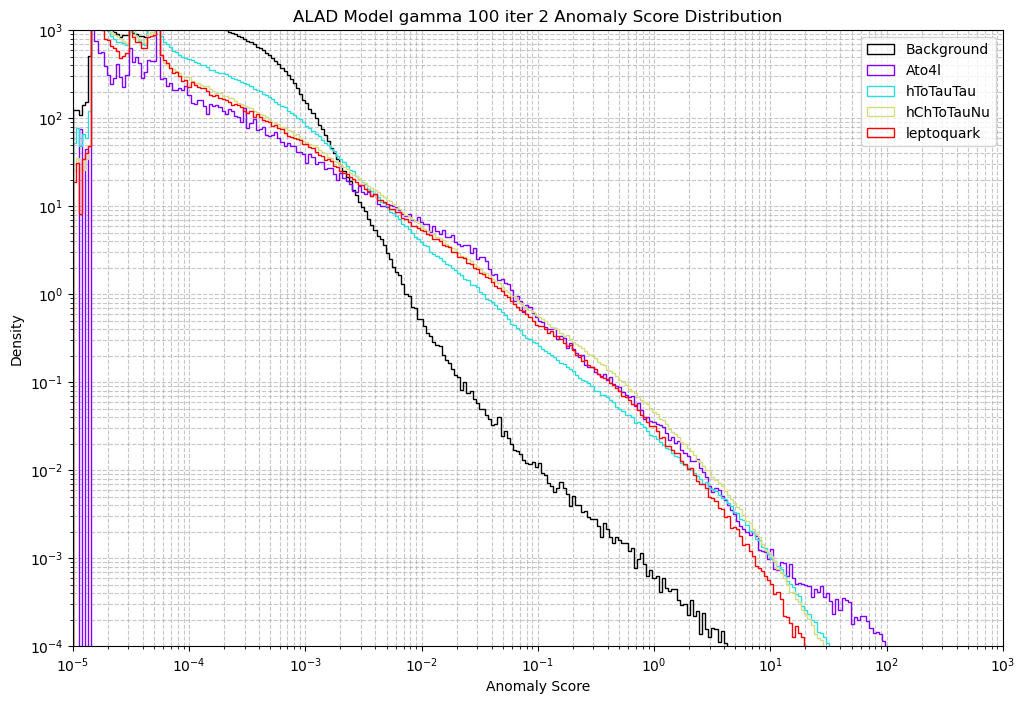


TPR at FPR = 1e-05 for each channel:
Ato4l: 2.090443%, Threshold = 108.894592
hToTauTau: 0.051932%, Threshold = 108.894592
hChToTauNu: 0.042485%, Threshold = 108.894592
leptoquark: 0.038174%, Threshold = 108.894592


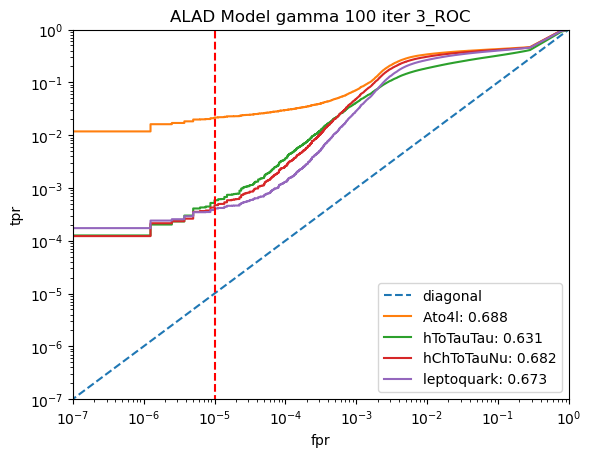


Mean Anomaly Scores:
Background: 0.016146
Ato4l: 66.597315
hToTauTau: 1.022837
hChToTauNu: 1.520188
leptoquark: 1.475210


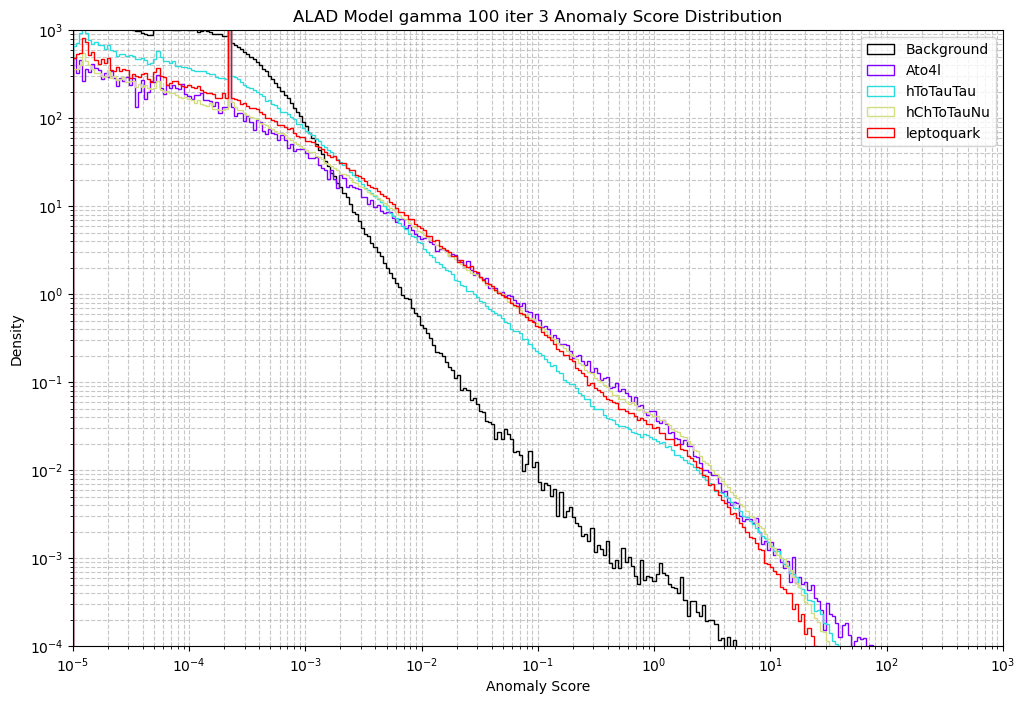


TPR at FPR = 1e-05 for each channel:
Ato4l: 2.640748%, Threshold = 109.551857
hToTauTau: 0.067122%, Threshold = 109.551857
hChToTauNu: 0.055901%, Threshold = 109.551857
leptoquark: 0.050801%, Threshold = 109.551857


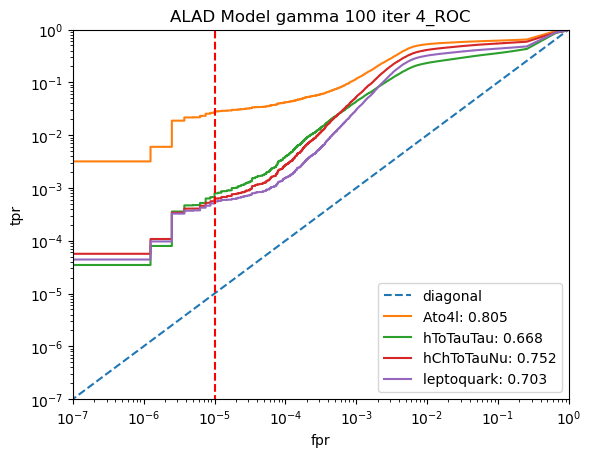


Mean Anomaly Scores:
Background: 0.019230
Ato4l: 41.882028
hToTauTau: 1.013702
hChToTauNu: 1.233026
leptoquark: 0.888435


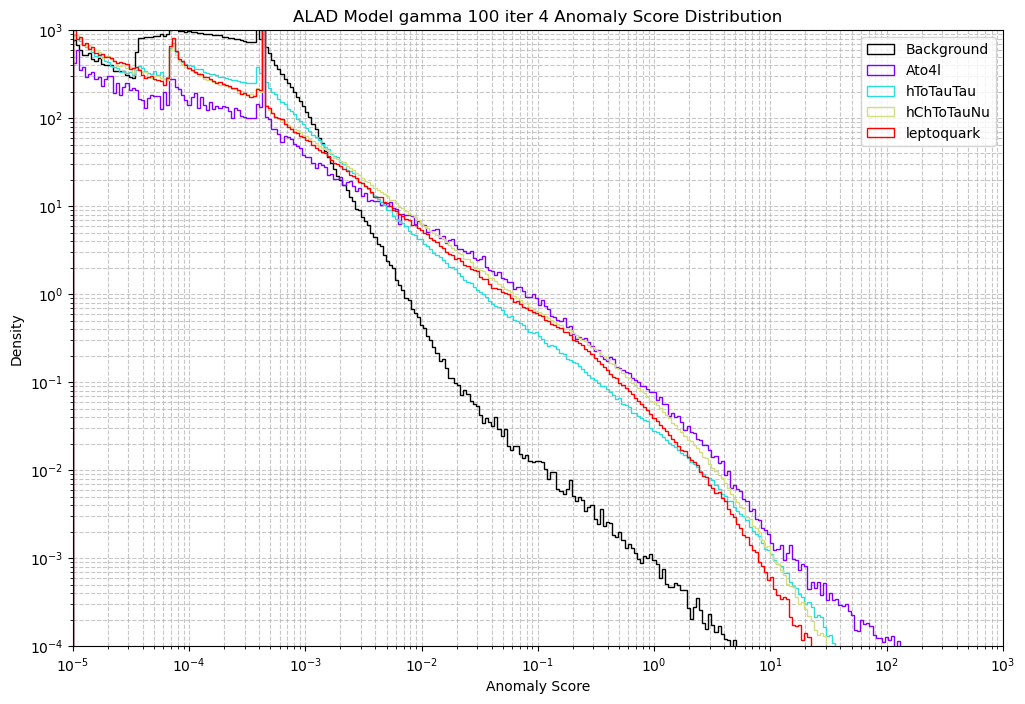


TPR at FPR = 1e-05 for each channel:
Ato4l: 1.779557%, Threshold = 125.091095
hToTauTau: 0.062203%, Threshold = 125.091095
hChToTauNu: 0.043142%, Threshold = 125.091095
leptoquark: 0.041698%, Threshold = 125.091095


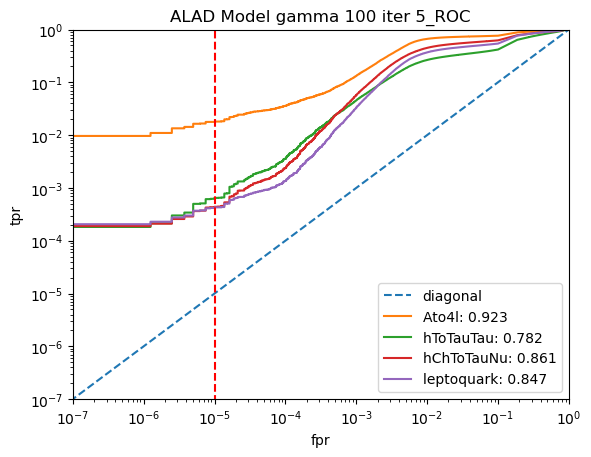


Mean Anomaly Scores:
Background: 0.015963
Ato4l: 228.487743
hToTauTau: 4.312113
hChToTauNu: 6.392161
leptoquark: 5.413229


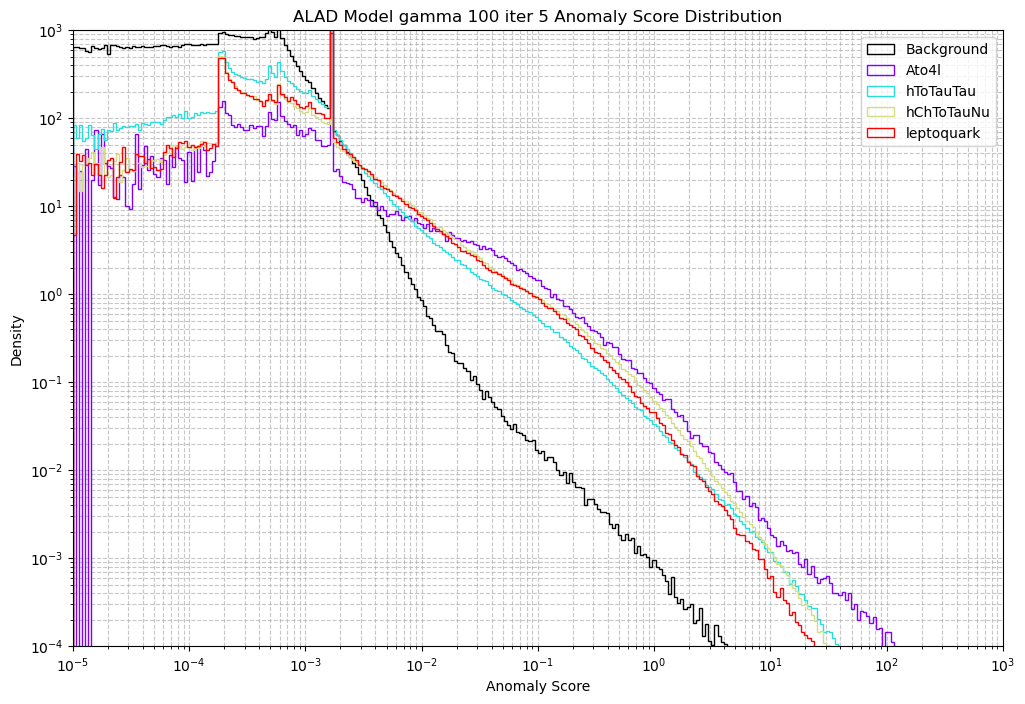


TPR at FPR = 1e-05 for each channel:
Ato4l: 2.840858%, Threshold = 130.966019
hToTauTau: 0.042964%, Threshold = 130.362457
hChToTauNu: 0.033935%, Threshold = 130.966019
leptoquark: 0.043166%, Threshold = 130.362457


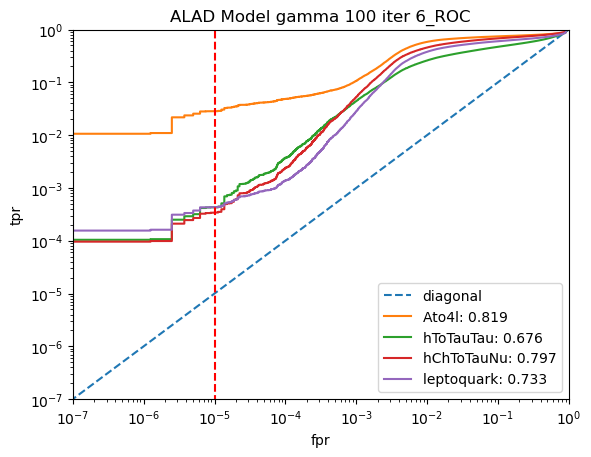


Mean Anomaly Scores:
Background: 0.019555
Ato4l: 48.322725
hToTauTau: 1.102466
hChToTauNu: 1.061177
leptoquark: 0.995242


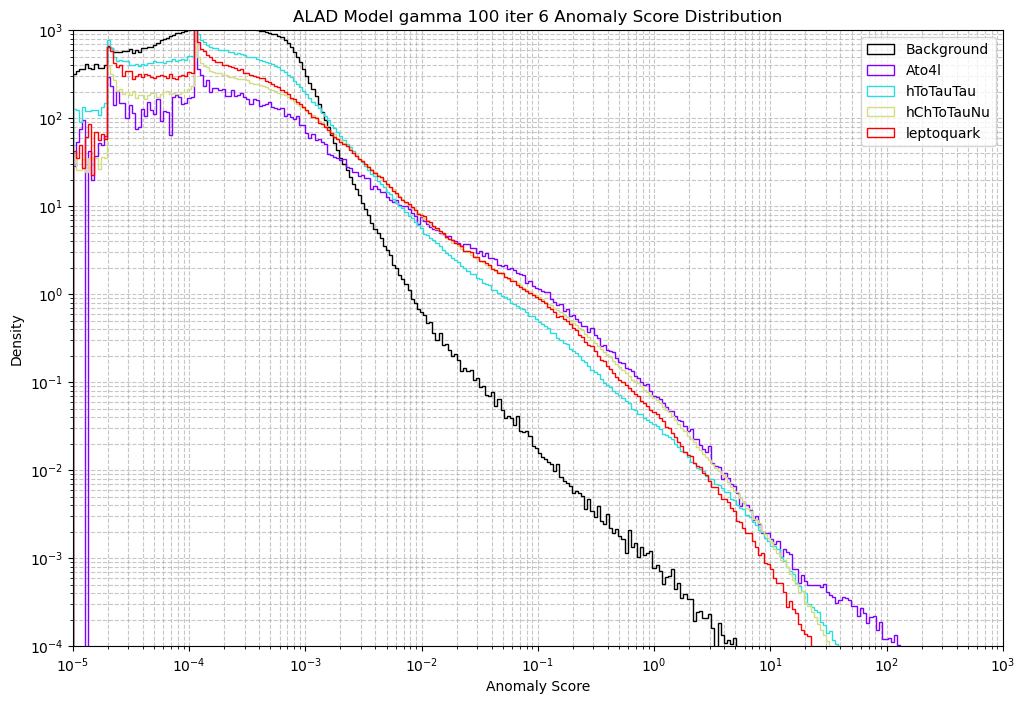


TPR at FPR = 1e-05 for each channel:
Ato4l: 4.029016%, Threshold = 105.308418
hToTauTau: 0.069147%, Threshold = 105.308418
hChToTauNu: 0.061162%, Threshold = 105.308418
leptoquark: 0.063722%, Threshold = 105.308418


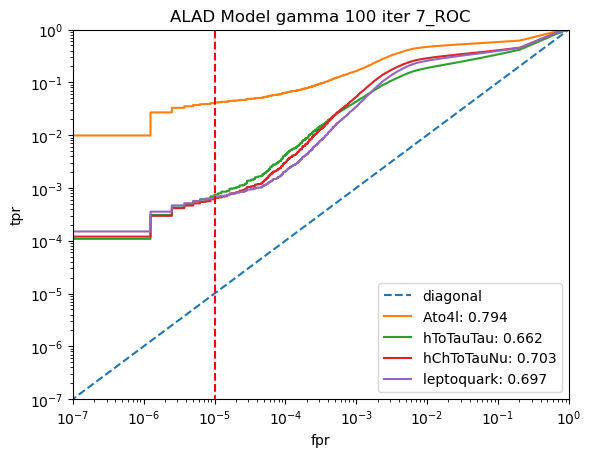


Mean Anomaly Scores:
Background: 0.013084
Ato4l: 75.146694
hToTauTau: 1.585945
hChToTauNu: 2.118677
leptoquark: 1.625305


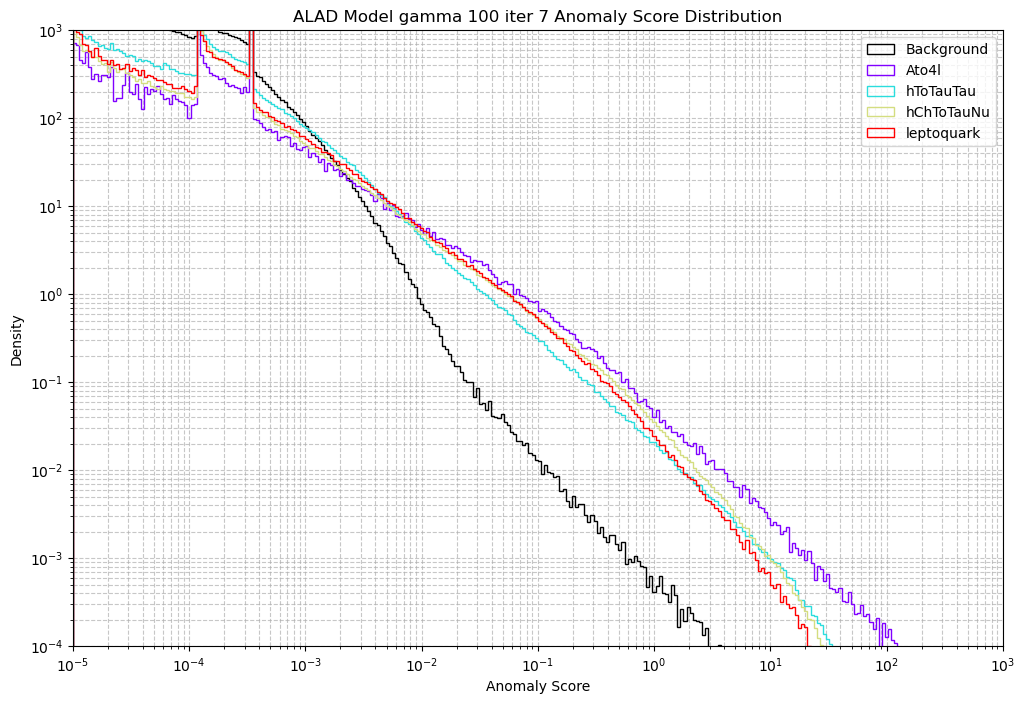


TPR at FPR = 1e-05 for each channel:
Ato4l: 3.861066%, Threshold = 135.500122
hToTauTau: 0.059165%, Threshold = 135.500122
hChToTauNu: 0.059058%, Threshold = 135.500122
leptoquark: 0.065483%, Threshold = 135.224503


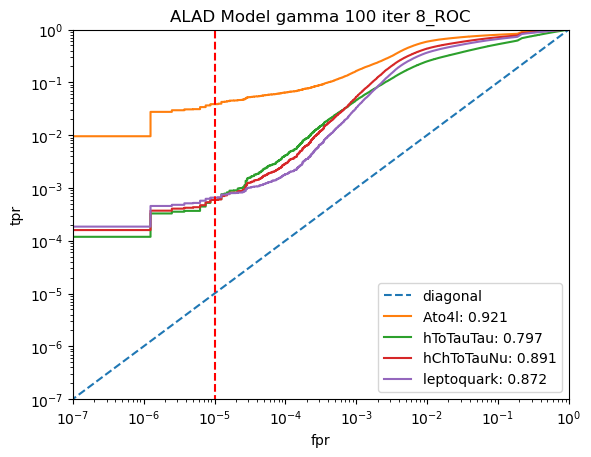


Mean Anomaly Scores:
Background: 0.018647
Ato4l: 53.684662
hToTauTau: 1.271093
hChToTauNu: 1.487373
leptoquark: 1.238666


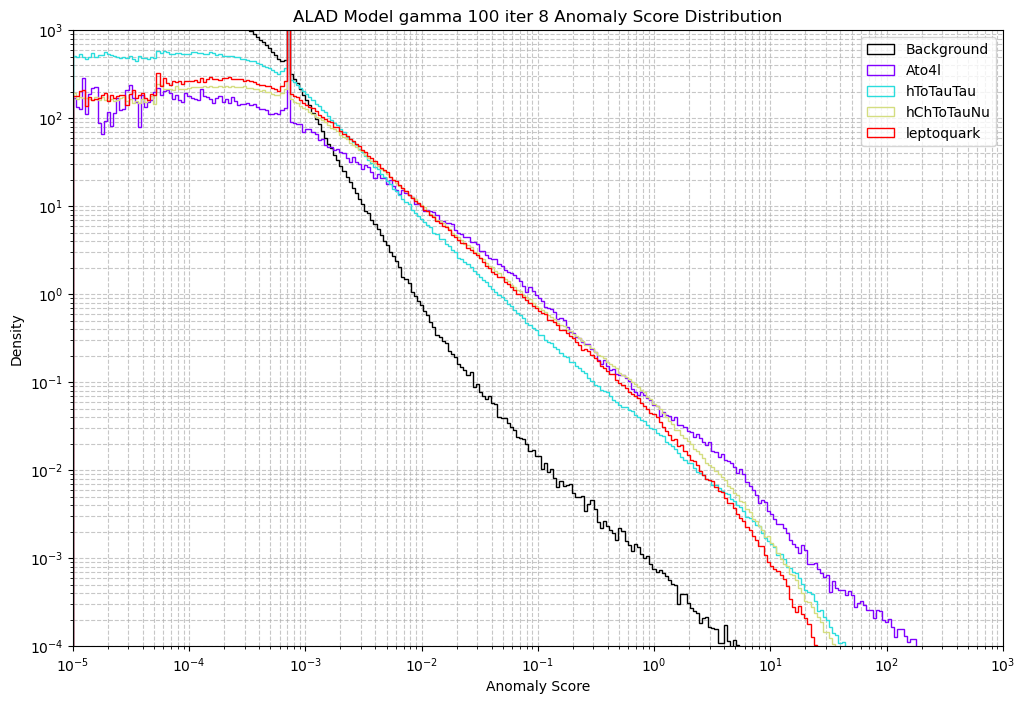


TPR at FPR = 1e-05 for each channel:
Ato4l: 3.627008%, Threshold = 100.111565
hToTauTau: 0.058442%, Threshold = 100.111565
hChToTauNu: 0.055770%, Threshold = 100.111565
leptoquark: 0.060198%, Threshold = 100.111565


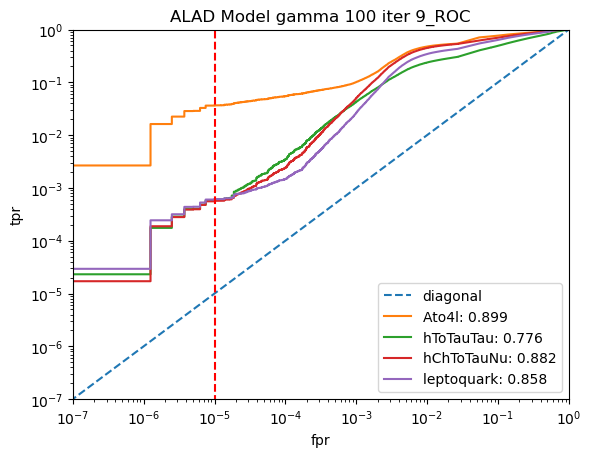


Mean Anomaly Scores:
Background: 0.065165
Ato4l: 331.234606
hToTauTau: 3.692056
hChToTauNu: 3.383657
leptoquark: 4.944747


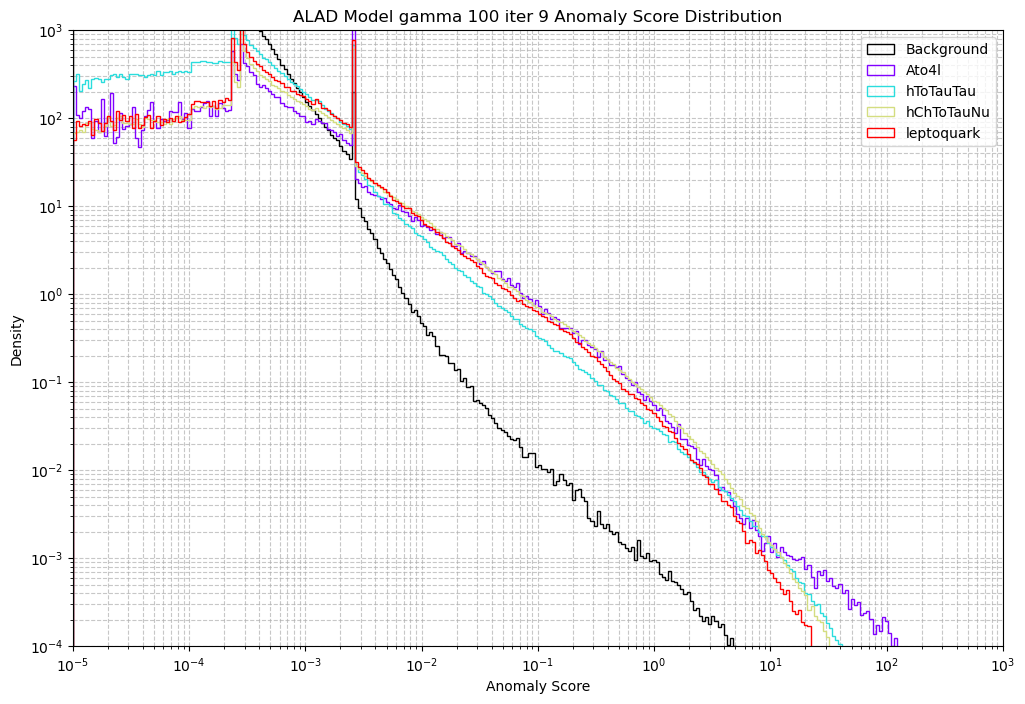

In [17]:
for i in range(1):
    for j in range(iters) : 
        curr_eval = evals[i][j]
        if curr_eval is not None:
            plot_ROC(curr_eval)
            plt.show()
            plot_anomaly_score_distribution(curr_eval, bins=300, range=(1e-5, 1e3))
            plt.show()
    # plt.xlim(0,40000)
    # plt.show()



TPR at FPR = 1e-05 for each channel:
Ato4l: 6.237381%, Threshold = 297.084412
hToTauTau: 0.122381%, Threshold = 297.084412
hChToTauNu: 0.100622%, Threshold = 297.084412
leptoquark: 0.097491%, Threshold = 297.084412


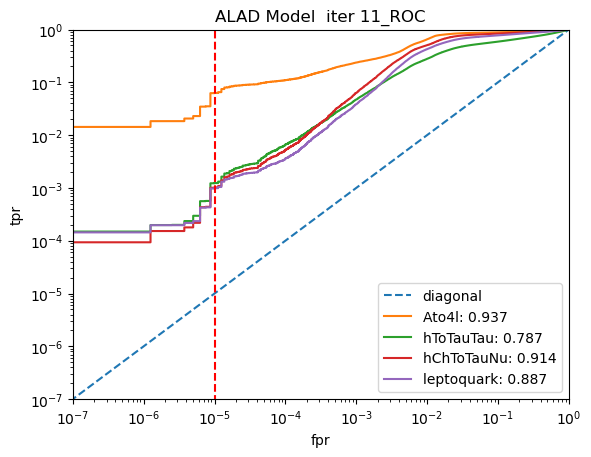


Mean Anomaly Scores:
Background: 0.048899
Ato4l: 207.649069
hToTauTau: 3.679420
hChToTauNu: 4.037450
leptoquark: 3.882860


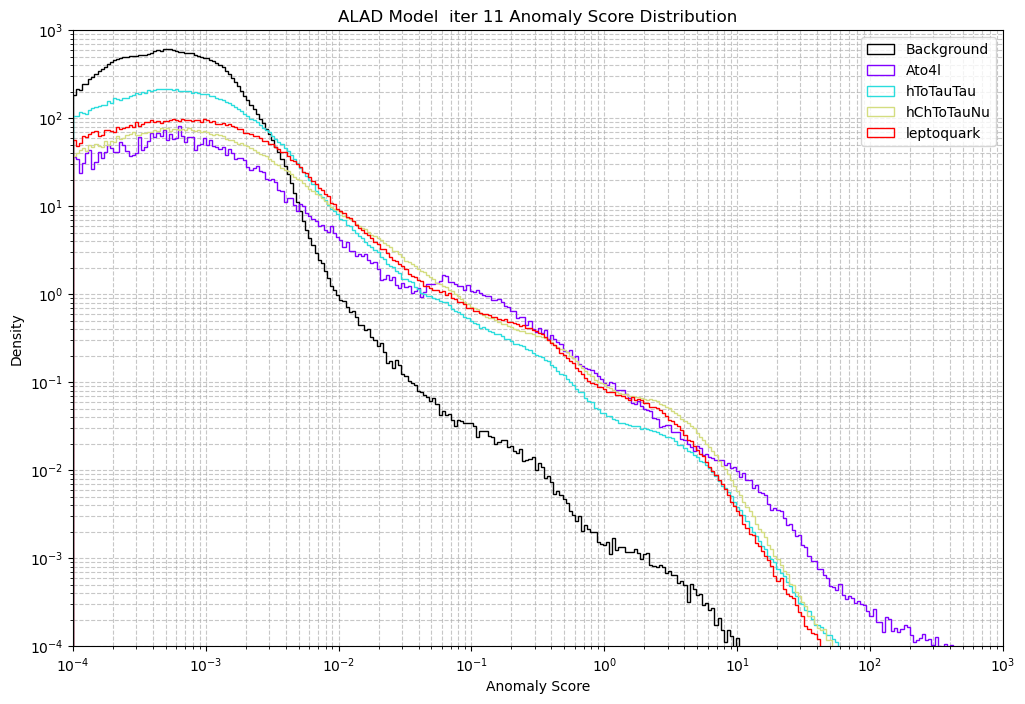


TPR at FPR = 1e-05 for each channel:
Ato4l: 6.271329%, Threshold = 133.577713
hToTauTau: 0.135834%, Threshold = 133.577713
hChToTauNu: 0.112065%, Threshold = 133.577713
leptoquark: 0.095436%, Threshold = 133.577713


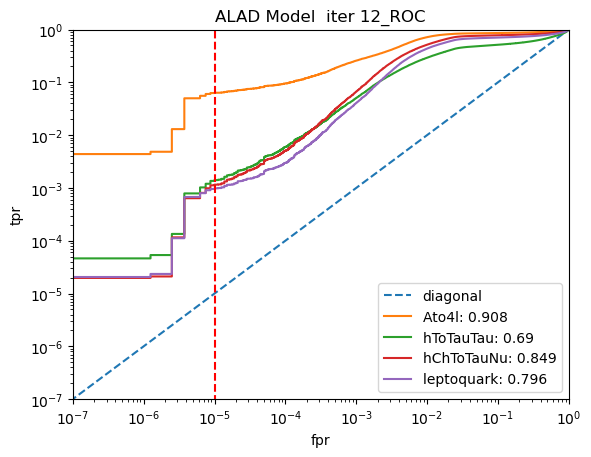


Mean Anomaly Scores:
Background: 0.034561
Ato4l: 57.312667
hToTauTau: 1.839861
hChToTauNu: 2.020016
leptoquark: 1.443083


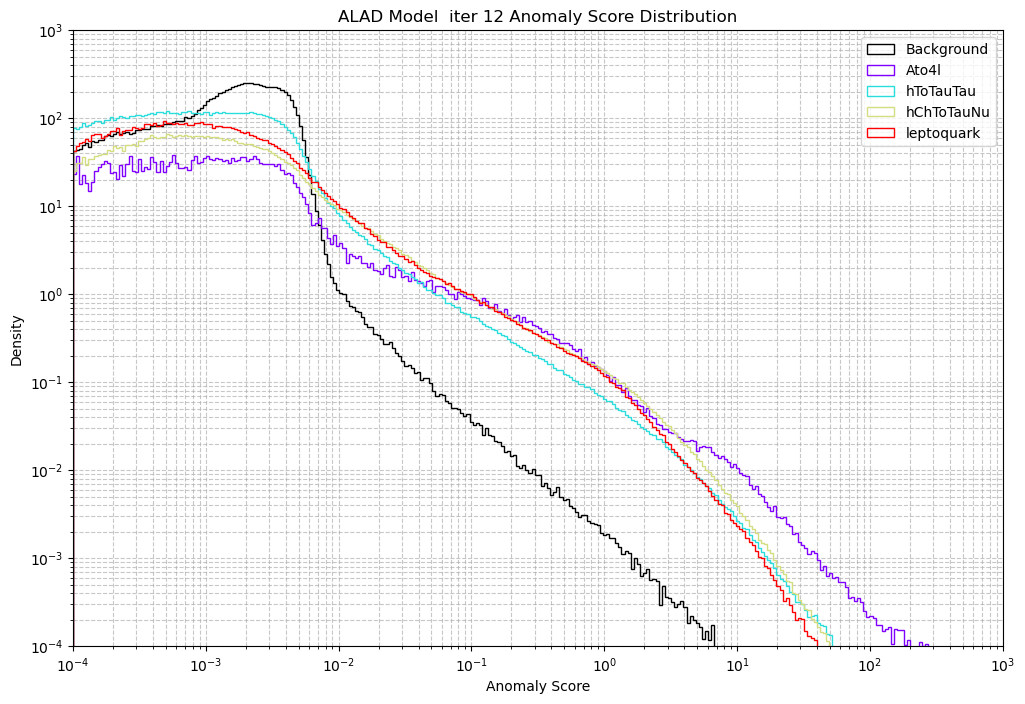

In [16]:
# gamma_increasing
notable_models = [
      (0,11),(0,12)
  # (5,2),
#   (0,4),(4,7),
  # (5,2),
#   (5,0)
  # (5,5)
]

for (i, j) in notable_models:

# for i in range(1):
#     for j in range(iters) : 
        curr_eval = evals[i][j]
        if curr_eval is not None:
            plot_ROC(curr_eval)
            plt.show()
            plot_anomaly_score_distribution(curr_eval, bins=300, range=(1e-4, 1e3))
            plt.show()
    # plt.xlim(0,40000)
    # plt.show()


In [ ]:
# LB
for i in range(1):
    for j in range(iters) : 
        curr_eval = evals[i][j]
        if curr_eval is not None:
            plot_ROC(curr_eval)
            plt.show()
            plot_anomaly_score_distribution(curr_eval, bins=300, range=(1e-2, 1e3))
            plt.show()
    # plt.xlim(0,40000)
    # plt.show()


In [ ]:
notable_models = [
  # (5,2),
  (0,4),(4,7),
  # (5,2),
  (5,0)
  # (5,5)
]

for (i, j) in notable_models:
  curr_eval = evals[i][j]
  thrs = get_threshold_from_ROC(curr_eval)
  # plot_anomaly_score_distribution(curr_eval, bins=300, range=(1e-1, 1e3))
  # plt.show()
  # plot_histogram(curr_eval, bins=100, bg_only=False)
  # plt.show()
  # plot_ROC(curr_eval)

In [ ]:
for i in range(1):
  for j in range(iters) : 
    curr_eval = evals[i][j]
    if curr_eval is not None:
        plot_anomaly_score_distribution(curr_eval, bins=300, range=(1e-1, 1e3))
        
    plt.show()


In [ ]:
labels_to_plot = ["Ato4l",
                "hToTauTau",
                "hChToTauNu",
                "leptoquark"
                ]

for i in range(1):
  for j in range(8) : 
    if evals[i][j]  is not None:
      curr_eval = evals[i][j] 
      # curr_eval.ROC(labels_to_plot=labels_to_plot)
      plot_ROC(curr_eval, labels_to_plot=labels_to_plot)
    plt.show()

In [20]:
channel_results.keys()

dict_keys(['Ato4l', 'hToTauTau', 'hChToTauNu', 'leptoquark'])

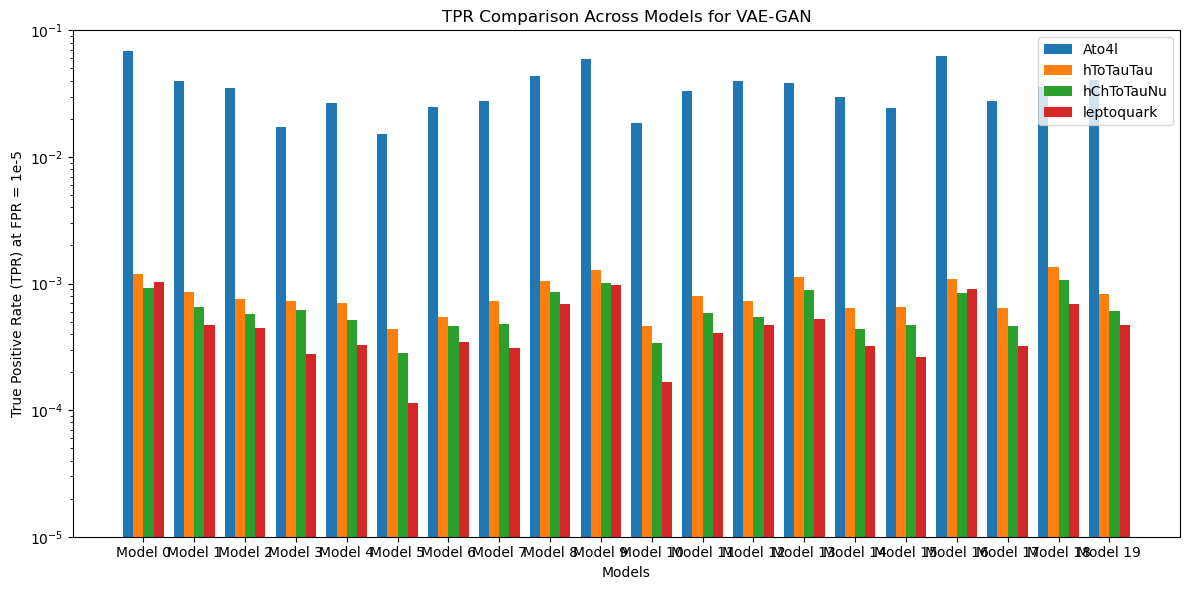


Channel Statistics:
Ato4l: Mean TPR = 3.5493%, Std Dev = 0.0143
hToTauTau: Mean TPR = 0.0828%, Std Dev = 0.0003
hChToTauNu: Mean TPR = 0.0630%, Std Dev = 0.0002
leptoquark: Mean TPR = 0.0476%, Std Dev = 0.0003


In [19]:
if channel_results:
    for g in range(1):
        plt.figure(figsize=(12, 6))
        channels = list(channel_results.keys())
        n_channels = len(channels)
        # n_models = len(channel_results[channels[0]][g])
        
        # x = np.arange(n_models)
        width = 0.8 / n_channels
        
        for i, channel in enumerate(channels):
            n_models = len(channel_results[channel][g])
            x = np.arange(n_models)

            tprs = channel_results[channel][g]
            plt.bar(x + i * width, tprs, width, label=channel)
        
        plt.xlabel('Models')
        plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
        # plt.title(f'TPR Comparison Across Models for Gamma={gamma_values[g]}')
        plt.title(f'TPR Comparison Across Models for VAE-GAN')
        plt.xticks(x + width * (n_channels - 1) / 2, [f'Model {i}' for i in range(n_models)])
        plt.yscale('log')
        plt.ylim(1e-5, 1e-1)
        plt.legend()
        plt.tight_layout()
        plt.savefig('VAE_tpr_comparison_plot.png', dpi=600, bbox_inches='tight')
        plt.show()
        
        # Print statistics
        print("\nChannel Statistics:")
        for channel in channels:
            tprs = channel_results[channel][g]
            mean = np.mean(tprs)
            std = np.std(tprs)
            print(f"{channel}: Mean TPR = {mean*100:.4f}%, Std Dev = {std:.4f}")
else:
    print("No results were obtained. Cannot create comparison plot.")

In [ ]:
if channel_results:
    plt.figure(figsize=(14, 8))  # Increased figure size to accommodate the legend
    channels = list(channel_results.keys())
    n_channels = len(channels)
    n_models = len(channel_results[channels[0]])
    
    for i, channel in enumerate(channels):
        tprs = channel_results[channel]
        plt.scatter(range(n_models), tprs, label=channel, s=50)
    
    plt.xlabel('Models')
    plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
    plt.semilogy()
    plt.title('TPR Comparison Across Models and Channels')
    plt.xticks(range(n_models), [f'{i}' for i in range(n_models)])
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Place legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('VAE_tpr_comparison_plot.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nChannel Statistics:")
    for channel in channels:
        tprs = channel_results[channel]
        mean = np.mean(tprs)
        std = np.std(tprs)
        print(f"{channel}: Mean TPR = {mean:.4f}, Std Dev = {std:.4f}")
else:
    print("No results were obtained. Cannot create comparison plot.")